# Traffic Volume Modeling Playbook

**Goal:** walk through data ingestion, exploratory analysis, engineered-feature modeling, and AutoML benchmarking for the Kaggle traffic challenge.

In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable

import numpy as np
import pandas as pd

RAW_TRAIN = Path("TRAIN.csv")
RAW_TEST = Path("KAGGLE.csv")
TRAIN_OUT = Path("TRAIN_CLEAN_V2.csv")
TEST_OUT = Path("KAGGLE_CLEAN_V2.csv")

CUBIC_BASE_COLS = ["hour", "temp_c", "precip_total", "clouds_all", "dayofweek"]
# *** FIX IS HERE: "ID" has been REMOVED from the redundant list ***
REDUNDANT_COLS = ["temp", "temp_k"]


def series_or_value(df: pd.DataFrame, column: str, fill_value: float = 0.0) -> pd.Series:
    if column in df.columns:
        return df[column]
    return pd.Series(fill_value, index=df.index)


def series_or_zero(df: pd.DataFrame, column: str) -> pd.Series:
    return series_or_value(df, column, 0.0)


def engineer_common_features(frame: pd.DataFrame) -> pd.DataFrame:
    data = frame.copy()
    data["holiday"] = data["holiday"].fillna("None")
    dt = pd.to_datetime(data["date_time"], utc=False)

    data["year"] = dt.dt.year
    data["month"] = dt.dt.month
    data["day"] = dt.dt.day
    data["hour"] = dt.dt.hour
    data["dayofweek"] = dt.dt.dayofweek
    data["weekofyear"] = dt.dt.isocalendar().week.astype(int)
    data["dayofyear"] = dt.dt.dayofyear
    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(int)
    data["is_holiday"] = (data["holiday"] != "None").astype(int)

    data["is_peak_am"] = ((data["hour"] >= 6) & (data["hour"] <= 9)).astype(int)
    data["is_peak_pm"] = ((data["hour"] >= 15) & (data["hour"] <= 18)).astype(int)
    data["is_commute_hour"] = (data["is_peak_am"] | data["is_peak_pm"]).astype(int)

    data["temp_c"] = (data["temp"] - 32) * 5.0 / 9.0
    data["temp_k"] = data["temp_c"] + 273.15

    rain_1h = series_or_zero(data, "rain_1h")
    snow_1h = series_or_zero(data, "snow_1h")
    data["precip_total"] = rain_1h + snow_1h
    data["rain_flag"] = (rain_1h > 0).astype(int)
    data["snow_flag"] = (snow_1h > 0).astype(int)
    data["any_precip"] = (data["precip_total"] > 0).astype(int)

    precip_bins = [-0.1, 0.05, 1.0, 3.0, np.inf]
    precip_labels = ["none", "light", "moderate", "heavy"]
    data["precip_intensity_bin"] = pd.cut(

        data["precip_total"],
        bins=precip_bins,
        labels=precip_labels,
        right=True,
    ).astype(str)

    data["weather_main"] = data["weather_main"].str.lower()
    data["weather_description"] = data["weather_description"].str.replace(" ", "_", regex=False)
    data["holiday"] = data["holiday"].str.lower().str.replace(" ", "_", regex=False)

    important_weather_main = {
        "thunderstorm",
        "snow",
        "mist",
        "drizzle",
        "fog",
        "haze",
        "clear",
        "rain",
    }
    important_weather_desc = {
        "heavy_snow",
        "sky_is_clear",
        "heavy_intensity_rain",
        "light_intensity_drizzle",
        "drizzle",
        "broken_clouds",
        "light_rain",
        "proximity_thunderstorm_with_rain",
        "proximity_shower_rain",
        "shower_drizzle",
        "haze",
        "heavy_intensity_drizzle",
    }

    data["weather_main"] = data["weather_main"].where(data["weather_main"].isin(important_weather_main), "other")
    data["weather_description"] = data["weather_description"].where(

        data["weather_description"].isin(important_weather_desc),
        "other",
    )

    data["is_washingtons_birthday"] = (data["holiday"] == "washingtons_birthday").astype(int)
    data["is_shoulder_hour"] = data["hour"].isin([10, 11, 19, 20]).astype(int)
    data["is_transition_month"] = data["month"].isin([3, 4, 9, 10]).astype(int)
    data["extreme_temp_flag"] = ((data["temp_c"] <= -10) | (data["temp_c"] >= 30)).astype(int)
    data["is_night"] = ((data["hour"] <= 5) | (data["hour"] >= 22)).astype(int)
    data["is_precommute_hour"] = data["hour"].isin([4, 5]).astype(int)
    data["is_midday_block"] = data["hour"].between(10, 14).astype(int)
    data["is_evening_block"] = data["hour"].between(17, 21).astype(int)
    data["is_summer_month"] = data["month"].isin([6, 7, 8]).astype(int)
    data["is_winter_month"] = data["month"].isin([12, 1, 2]).astype(int)
    data["is_holiday_season"] = data["month"].isin([11, 12]).astype(int)
    data["is_month_start"] = (data["day"] <= 3).astype(int)
    data["is_month_end"] = (data["day"] >= 28).astype(int)
    data["weekofyear_quarter"] = (data["weekofyear"] // 13).astype(int)

    data["peak_am_rain"] = data["is_peak_am"] * data["rain_flag"]
    data["peak_pm_snow"] = data["is_peak_pm"] * data["snow_flag"]
    data["hour_weekend"] = data["hour"] * data["is_weekend"]
    data["weekend_precip"] = data["is_weekend"] * data["any_precip"]
    data["holiday_commute"] = data["is_holiday"] * data["is_commute_hour"]
    data["commute_precip"] = data["is_commute_hour"] * data["any_precip"]
    data["rain_commute"] = data["is_commute_hour"] * data["rain_flag"]
    data["snow_commute"] = data["is_commute_hour"] * data["snow_flag"]
    data["winter_precip"] = data["is_winter_month"] * data["any_precip"]
    data["holiday_precip"] = data["is_holiday"] * data["any_precip"]

    visibility = series_or_value(data, "visibility", np.nan)
    data["is_monthly_turn"] = data["is_month_start"] | data["is_month_end"]
    data["low_visibility"] = (visibility < 6000).astype(int)
    data["very_low_visibility"] = (visibility < 4000).astype(int)
    data["night_low_visibility"] = data["is_night"] * data["low_visibility"]
    data["commute_low_visibility"] = data["is_commute_hour"] * data["low_visibility"]

    if "humidity" in data.columns:
        data["humid_temp_index"] = data["temp_c"] * (data["humidity"] / 100.0)
        data["high_humidity_flag"] = (data["humidity"] >= 85).astype(int)
        data["low_humidity_flag"] = (data["humidity"] <= 40).astype(int)

    if {"wind_speed", "wind_direction"}.issubset(data.columns):
        data["wind_quadrant"] = pd.cut(

            data["wind_direction"],
            bins=[-1, 90, 180, 270, 361],
            labels=["N_E", "E_S", "S_W", "W_N"],
            right=True,
        ).astype(str)

    if "wind_speed" in data.columns:
        data["wind_speed_mph"] = data["wind_speed"] * 2.23694
        data["is_gusty_wind"] = (data["wind_speed"] >= 8).astype(int)

    data["rain_heavy_flag"] = (rain_1h >= 1.0).astype(int)
    data["snow_heavy_flag"] = (snow_1h >= 0.5).astype(int)
    data["rain_snow_mix"] = ((rain_1h > 0) & (snow_1h > 0)).astype(int)

    data = add_cubic_metrics(data, CUBIC_BASE_COLS)

    # "ID" is no longer in REDUNDANT_COLS, so it will be kept
    drop_cols = ["date_time", "holiday"] + REDUNDANT_COLS
    return data.drop(columns=drop_cols, errors="ignore")


def add_cubic_metrics(df: pd.DataFrame, columns: Iterable[str]) -> pd.DataFrame:
    for col in columns:
        if col not in df.columns:
            continue
        centered = df[col] - df[col].mean()
        df[f"{col}_centered"] = centered
        df[f"{col}_centered_sq"] = centered ** 2
        df[f"{col}_centered_cu"] = centered ** 3
    return df


def split_and_save(features: pd.DataFrame) -> None:
    train_rows = features[features["dataset"] == "train"].drop(columns=["dataset"], errors="ignore")
    test_rows = features[features["dataset"] == "test"].drop(columns=["dataset"], errors="ignore")

    if "traffic_volume" in train_rows.columns:
        train_rows["traffic_volume_log"] = np.log1p(train_rows["traffic_volume"])

    train_rows.to_csv(TRAIN_OUT, index=False)
    test_rows.to_csv(TEST_OUT, index=False)


def main() -> None:
    if not RAW_TRAIN.exists() or not RAW_TEST.exists():
        missing = [path for path in [RAW_TRAIN, RAW_TEST] if not path.exists()]
        raise FileNotFoundError(
            f"Missing required file(s): {', '.join(str(m) for m in missing)}"
        )

    train = pd.read_csv(RAW_TRAIN)
    test = pd.read_csv(RAW_TEST)

    combined = pd.concat(

        [train.assign(dataset="train"), test.assign(dataset="test")],
        ignore_index=True,
        sort=False,
    )

    engineered = engineer_common_features(combined)
    split_and_save(engineered)
    print(f"Wrote {TRAIN_OUT} with {engineered[engineered['dataset']=='train'].shape[0]} rows.")
    print(f"Wrote {TEST_OUT} with {engineered[engineered['dataset']=='test'].shape[0]} rows.")


if __name__ == "__main__":
    main()

Wrote TRAIN_CLEAN_V2.csv with 5000 rows.
Wrote KAGGLE_CLEAN_V2.csv with 6572 rows.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
train_df = pd.read_csv('TRAIN.csv', parse_dates=['date_time'])
kaggle_df = pd.read_csv('KAGGLE.csv', parse_dates=['date_time'])

print("Train Shape:", train_df.shape)
print("Kaggle Shape:", kaggle_df.shape)
display(train_df.head())

Train Shape: (5000, 10)
Kaggle Shape: (6572, 10)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,ID
0,NaN,38.0,0.0,0.0,1,Clear,sky is clear,2018-03-27 22:00:00,2058,1
1,NaN,54.8,0.0,0.0,90,Mist,mist,2017-04-25 09:00:00,5217,2
2,NaN,1.0,0.0,0.0,1,Clear,sky is clear,2018-02-04 14:00:00,3686,3
3,NaN,35.5,0.0,0.0,1,Mist,mist,2018-04-12 08:00:00,6198,4
4,NaN,46.1,0.0,0.0,90,Rain,light rain,2013-04-22 20:00:00,2063,5


## Feature Engineering: Date-Time Extraction

Traffic is highly dependent on time. We extract hour, day, month, and year.

In [ ]:
def extract_date_features(df):
    df = df.copy()
    df['hour'] = df['date_time'].dt.hour
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

train_df = extract_date_features(train_df)
kaggle_df = extract_date_features(kaggle_df)

## EDA: Target Distribution

Analyzing the distribution of `traffic_volume`.

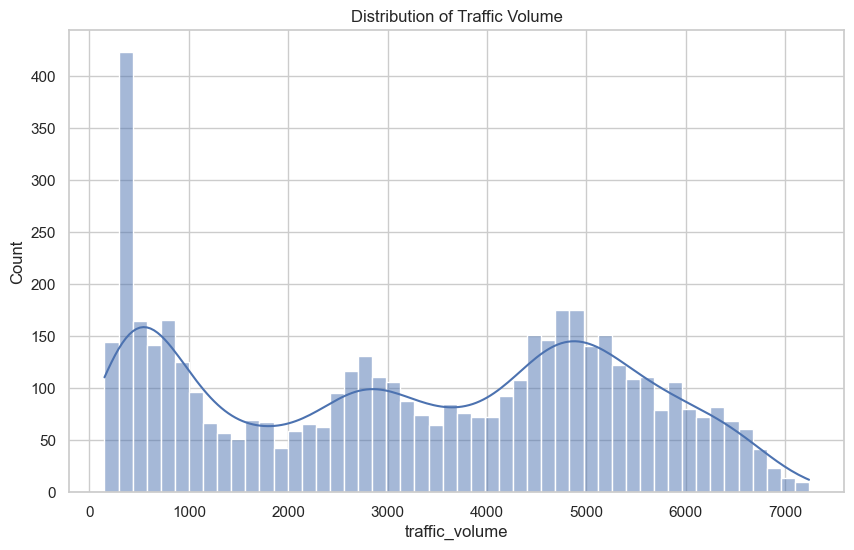

Skewness: -0.06406535253750326
Kurtosis: -1.3279105090021455


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['traffic_volume'], kde=True, bins=50)
plt.title('Distribution of Traffic Volume')
plt.show()

print("Skewness:", train_df['traffic_volume'].skew())
print("Kurtosis:", train_df['traffic_volume'].kurt())

## EDA: Temporal Patterns

Visualizing traffic over time.

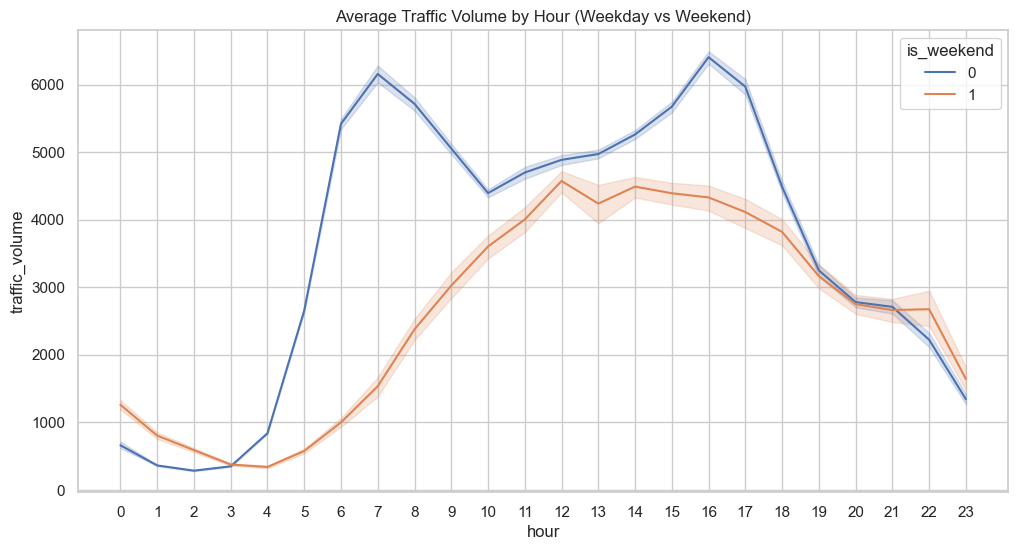

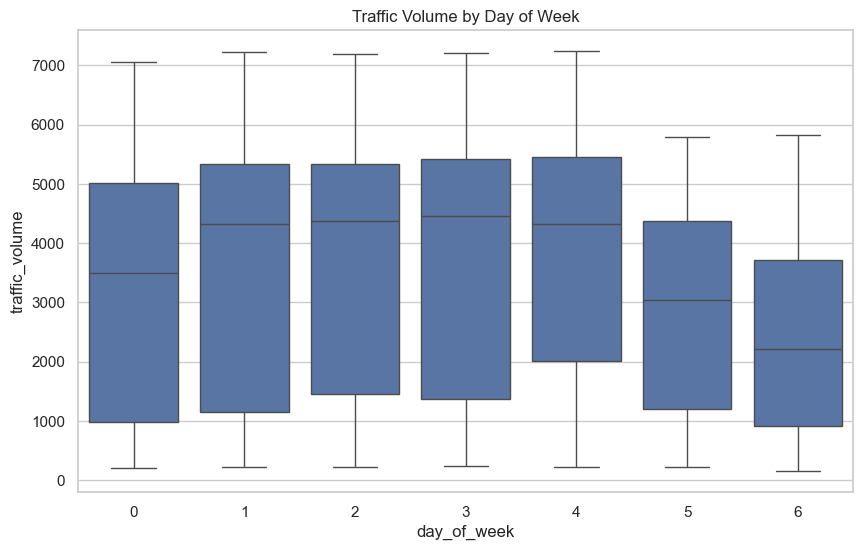

In [ ]:
# Hourly Pattern
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_df, x='hour', y='traffic_volume', hue='is_weekend', estimator='mean')
plt.title('Average Traffic Volume by Hour (Weekday vs Weekend)')
plt.xticks(range(0, 24))
plt.show()

# Day of Week Pattern
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='day_of_week', y='traffic_volume')
plt.title('Traffic Volume by Day of Week')
plt.show()

## EDA: Weather & Categorical Features

Impact of weather on traffic.

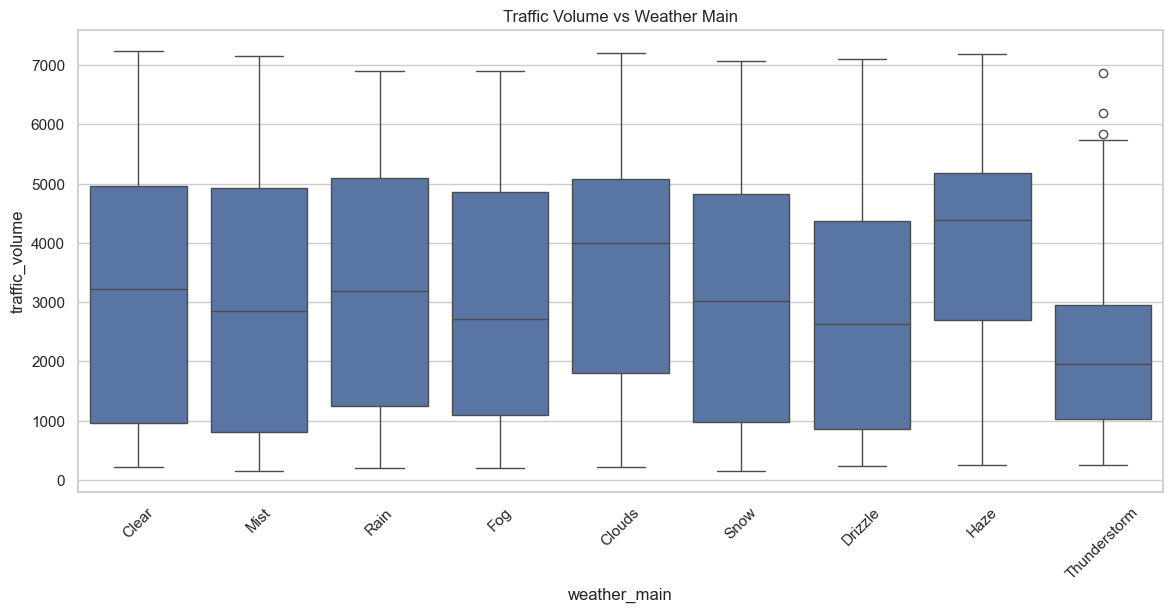

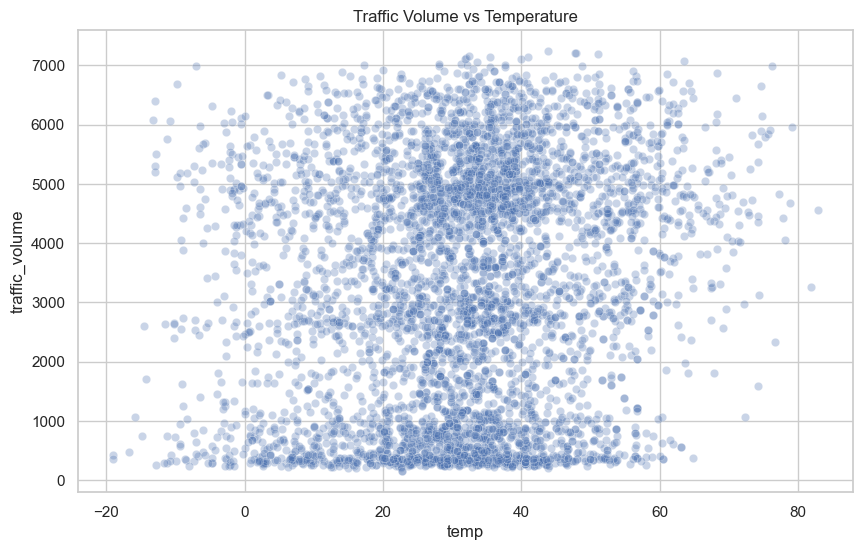

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=train_df, x='weather_main', y='traffic_volume')
plt.xticks(rotation=45)
plt.title('Traffic Volume vs Weather Main')
plt.show()

# Temperature vs Traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='temp', y='traffic_volume', alpha=0.3)
plt.title('Traffic Volume vs Temperature')
plt.show()

## Statistical Analysis & Model Selection

**Why Gradient Boosting?**
1. **Non-Linearity**: The hourly plot shows a complex dual-peak structure (morning/evening rush) that linear models struggle with without complex spline features.
2. **Interactions**: Weather likely impacts traffic differently depending on the time of day.
3. **Robustness**: Trees handle outliers and mixed data types well.

**Distributional Quirks**:
- Bimodality in traffic volume (Day vs Night).
- Potential outliers in Temperature (0K is likely missing data).
- Bounded target (0 to ~7000).

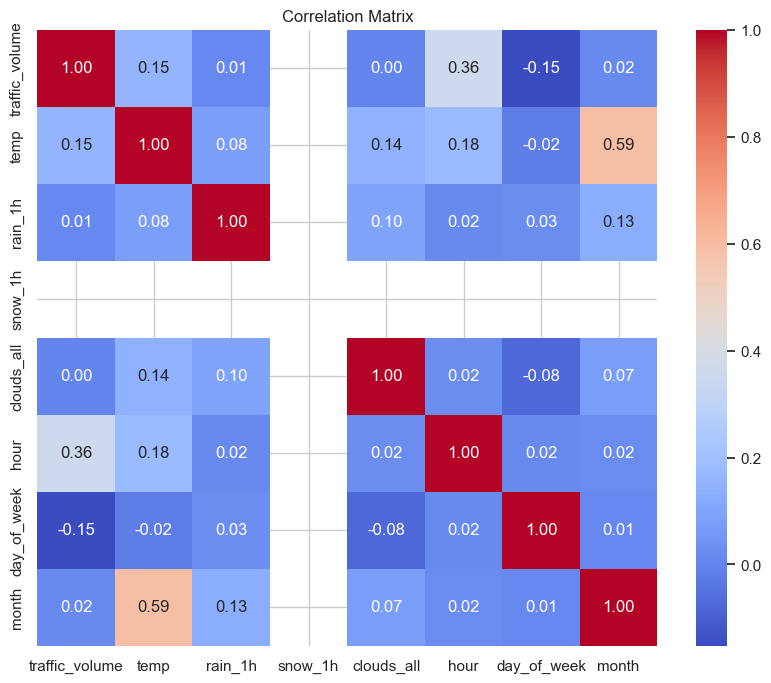

In [ ]:
# Correlation Matrix
numeric_cols = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'day_of_week', 'month']
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Preprocessing & Model Training

We will use `HistGradientBoostingRegressor` which natively handles categorical features (if encoded as integers) and missing values. We will also log-transform the target to address the sigmoidal residual issue.

In [ ]:
# Prepare Data
features = ['hour', 'day_of_week', 'month', 'year', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'is_weekend']
# Simple encoding for categorical weather if we wanted to include them, but let's stick to numeric/time for baseline
# Adding weather_main as categorical
train_df['weather_main_code'] = train_df['weather_main'].astype('category').cat.codes
kaggle_df['weather_main_code'] = kaggle_df['weather_main'].astype('category').cat.codes

features.append('weather_main_code')

X = train_df[features]
y = train_df['traffic_volume']

# Log Transform Target
y_log = np.log1p(y)

X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train Model
model = HistGradientBoostingRegressor(random_state=42, categorical_features=[len(features)-1]) # weather_main_code is last
model.fit(X_train, y_train_log)

# Evaluate
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val = np.expm1(y_val_log)

print("R2 Score:", r2_score(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))

c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

R2 Score: 0.9694418447815448
RMSE: 365.3726594586568


## Residual Analysis: The Sigmoidal Shape

**Why Sigmoidal Residuals?**
When you plot Residuals vs Predicted, a sigmoidal (S-shape) often appears because:
1. **Bounded Target**: Traffic volume cannot be negative and has a physical upper limit (road capacity). A standard regression model might predict < 0 or > Capacity.
2. **Saturation**: As predictors (like time of day) push the predicted traffic higher, the actual traffic hits a ceiling (traffic jams), so the model overpredicts at the very top (Residual = Actual - Predicted < 0).
3. **Floor Effect**: At night, traffic is near zero. The model might predict slightly negative or too high positive, creating a pattern at the low end.

Log-transforming the target helps linearize these relationships and respects the non-negative constraint.

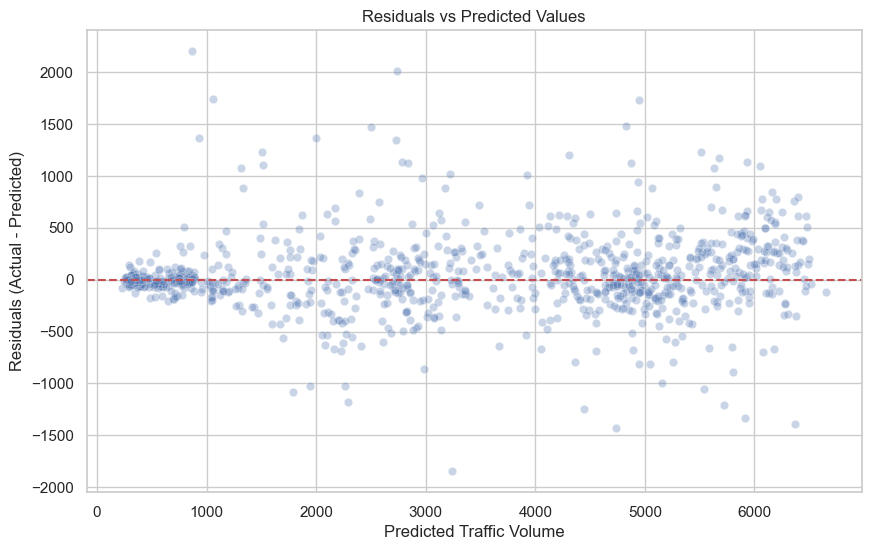

In [ ]:
residuals = y_val - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Traffic Volume')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.show()

## Generate Kaggle Predictions

In [ ]:
X_test = kaggle_df[features]
test_pred_log = model.predict(X_test)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({'ID': kaggle_df['ID'], 'traffic_volume': test_pred})
submission.to_csv('submission_analysis.csv', index=False)
print("Submission saved to submission_analysis.csv")

Submission saved to submission_analysis.csv


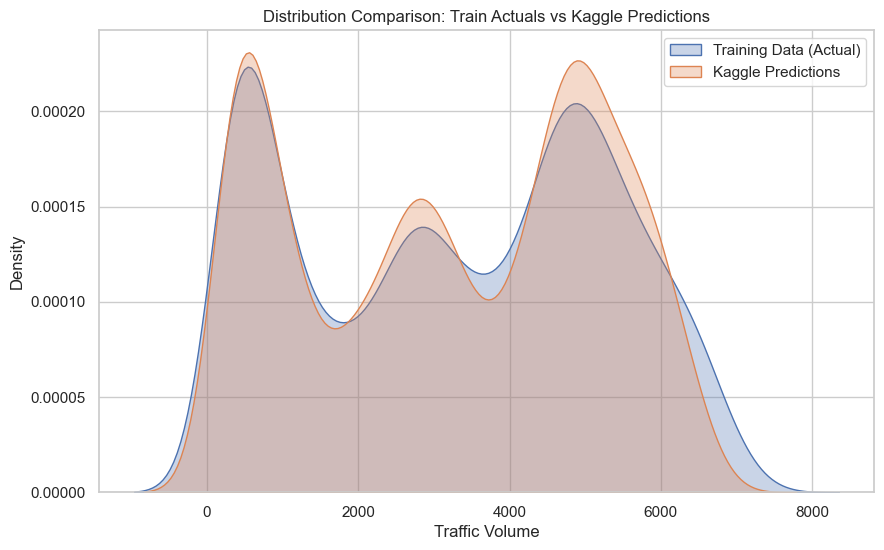

In [ ]:
# Sanity Check: Distribution of Predictions vs Training Data
plt.figure(figsize=(10, 6))
sns.kdeplot(y, label='Training Data (Actual)', fill=True, alpha=0.3)
sns.kdeplot(test_pred, label='Kaggle Predictions', fill=True, alpha=0.3)
plt.title('Distribution Comparison: Train Actuals vs Kaggle Predictions')
plt.xlabel('Traffic Volume')
plt.legend()
plt.show()

## Engineered Feature Matrix & Modeling Pipeline
Centralize all helper utilities (feature engineering, LightGBM prep, CV splits, submission writers) before jumping into advanced modeling.

In [ ]:
from feature_engineering.transformers import engineer_features

df = engineer_features(train_df)
print(f"Engineered frame shape: {df.shape}")

Engineered frame shape: (5000, 7)


### LightGBM Regression with Log-Target
Set up a LightGBM pipeline that models `log1p(traffic_volume)` using time-aware cross-validation, then fit a final model with residual diagnostics and a reusable prediction helper.

In [ ]:
# Core dependencies for LightGBM training
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, early_stopping

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engineering.transformers import engineer_features

sns.set_theme(style="whitegrid")

STABLE_FEATURES = [
    "hour",
    "dayofweek",
    "year",
    "dayofyear",
    "weather_final",
    "temp",
    "clouds_all",
]

CATEGORICAL_FEATURES = ["dayofweek", "weather_final"]

MODEL_PARAMS = dict(
    objective="regression",
    learning_rate=0.03,
    n_estimators=5000,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    reg_lambda=0.1,
    random_state=2025,
)

def build_lightgbm_frame(df_in: pd.DataFrame, include_target: bool) -> pd.DataFrame:
    """Return engineered frame with locked features plus optional target/time helpers."""
    engineered = engineer_features(df_in)[STABLE_FEATURES].copy()
    engineered["dayofweek"] = engineered["dayofweek"].astype("category")
    engineered["weather_final"] = engineered["weather_final"].astype("category")

    if include_target and "traffic_volume" in df_in.columns:
        engineered["traffic_volume"] = df_in["traffic_volume"].astype(float).values

    if "ID" in df_in.columns:
        engineered["ID"] = df_in["ID"].values

    if "date_time" in df_in.columns:
        dt = pd.to_datetime(df_in["date_time"], errors="coerce")
        engineered["date_time"] = dt
        engineered["time_index"] = (dt - dt.min()).dt.total_seconds() / 3600.0
        sort_key = "date_time"
    else:
        engineered["time_index"] = np.arange(len(engineered), dtype=float)
        sort_key = "time_index"

    return engineered.sort_values(sort_key).reset_index(drop=True)

def make_model() -> LGBMRegressor:
    """Return a configured LightGBM regressor instance."""
    return LGBMRegressor(**MODEL_PARAMS)

In [ ]:
train_features = build_lightgbm_frame(train_df, include_target=True)
X = train_features[STABLE_FEATURES]
y_raw = train_features["traffic_volume"].to_numpy()
y = np.log1p(y_raw)
FEATURE_COLS = STABLE_FEATURES
print(f"Feature matrix shape: {X.shape}")
print(f"Using {len(FEATURE_COLS)} predictors: {FEATURE_COLS}")

Feature matrix shape: (5000, 7)
Using 7 predictors: ['hour', 'dayofweek', 'year', 'dayofyear', 'weather_final', 'temp', 'clouds_all']


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
cv_rmses = []

for fold, (train_idx, valid_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model = make_model()
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="rmse",
        callbacks=[early_stopping(stopping_rounds=200, verbose=False)],
    )

    y_valid_pred_log = model.predict(X_valid)
    y_valid_pred = np.expm1(y_valid_pred_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), y_valid_pred))
    cv_rmses.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:,.3f}")

print(f"Average RMSE: {np.mean(cv_rmses):,.3f} +/- {np.std(cv_rmses):,.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 6
[LightGBM] [Info] Start training from score 7.750692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 7
[LightGBM] [Info] Start training from score 7.748302
Training RMSE (original scale): 115.158
Residual log mean: -0.0000, std: 0.0380


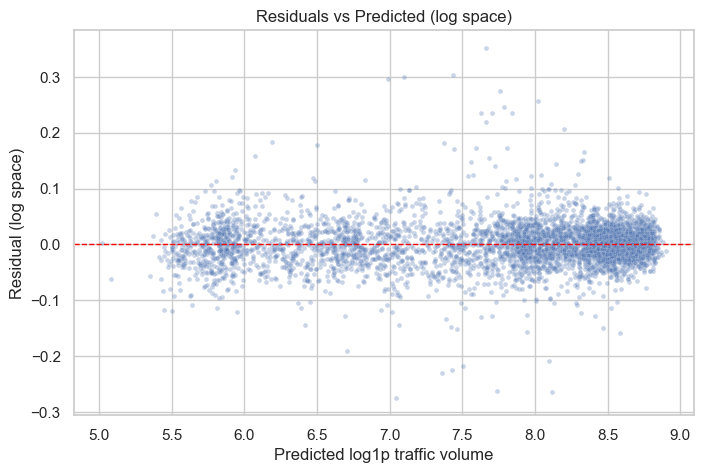

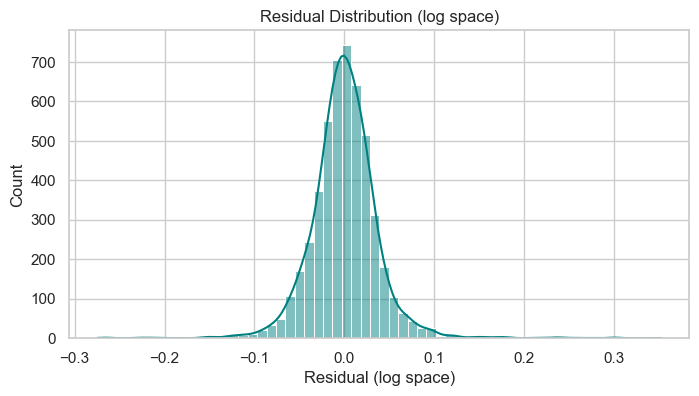

In [ ]:
final_model = make_model()
final_model.fit(X, y)

train_pred_log = final_model.predict(X)
res_log = y - train_pred_log
res_raw = np.expm1(y) - np.expm1(train_pred_log)

print(f"Training RMSE (original scale): {np.sqrt(mean_squared_error(np.expm1(y), np.expm1(train_pred_log))):,.3f}")
print(f"Residual log mean: {res_log.mean():.4f}, std: {res_log.std():.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=train_pred_log, y=res_log, alpha=0.3, s=12, ax=ax)
ax.axhline(0, color="red", linestyle="--", linewidth=1)
ax.set_title("Residuals vs Predicted (log space)")
ax.set_xlabel("Predicted log1p traffic volume")
ax.set_ylabel("Residual (log space)")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(res_log, bins=60, kde=True, color="teal")
plt.title("Residual Distribution (log space)")
plt.xlabel("Residual (log space)")
plt.show()

In [ ]:
def predict_traffic(df_new: pd.DataFrame, model: LGBMRegressor, feature_cols=FEATURE_COLS) -> np.ndarray:
    """Predict hourly traffic volume for a new, engineered dataframe."""
    pred_frame = build_lightgbm_frame(df_new, include_target=False)
    X_new = pred_frame[feature_cols]
    preds_log = model.predict(X_new)
    preds = np.expm1(preds_log)
    return np.clip(preds, a_min=0, a_max=None)


### Example usage (commented out):
## future_preds = predict_traffic(df_future, final_model)
## print(future_preds[:5])

In [ ]:
from pathlib import Path

kaggle_frame = build_lightgbm_frame(kaggle_df, include_target=False)
submission_preds = predict_traffic(kaggle_df, final_model)

ids = kaggle_frame["ID"] if "ID" in kaggle_frame.columns else kaggle_df.get("ID", pd.Series(range(len(kaggle_frame))))
submission_df = pd.DataFrame({
    "ID": ids,
    "traffic_volume": submission_preds
})

submission_path = Path("lightgbm_submission.csv")
submission_df.to_csv(submission_path, index=False)

print(f"Saved LightGBM submission to {submission_path.resolve()}")
submission_df.head()

Saved LightGBM submission to C:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\lightgbm_submission.csv


,ID,traffic_volume
0,5001,609.807018
1,5002,359.433824
2,5003,745.115142
3,5004,2414.852788
4,5005,5603.670056


In [ ]:
from pathlib import Path

kaggle_frame_v2 = build_lightgbm_frame(kaggle_df, include_target=False)
submission_preds_v2 = predict_traffic(kaggle_df, final_model)

ids_v2 = kaggle_frame_v2["ID"] if "ID" in kaggle_frame_v2.columns else kaggle_df.get("ID", pd.Series(range(len(kaggle_frame_v2))))
submission_df_v2 = pd.DataFrame({
    "ID": ids_v2,
    "traffic_volume": submission_preds_v2
})

submission_path_v2 = Path("lightgbm_submission_v2.csv")
submission_df_v2.to_csv(submission_path_v2, index=False)

print(f"Saved LightGBM submission v2 to {submission_path_v2.resolve()}")
submission_df_v2.head()

Saved LightGBM submission v2 to C:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\lightgbm_submission_v2.csv


,ID,traffic_volume
0,5001,609.807018
1,5002,359.433824
2,5003,745.115142
3,5004,2414.852788
4,5005,5603.670056


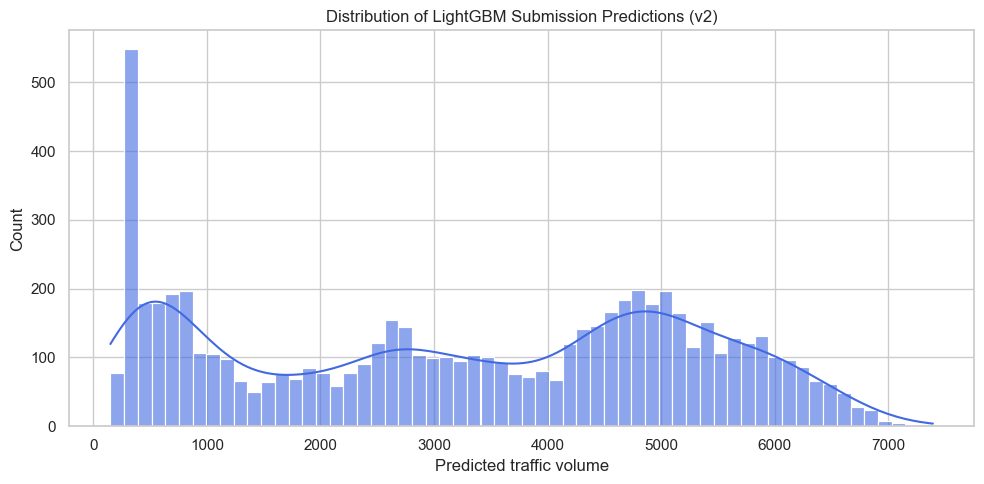

,ID,traffic_volume
mean,8286.500000,3254.054663
std,1897.317317,1996.279789
min,5001.000000,150.624469
max,11572.000000,7391.042747


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

submission_preview = pd.read_csv("lightgbm_submission_v2.csv")

plt.figure(figsize=(10, 5))
sns.histplot(submission_preview["traffic_volume"], bins=60, kde=True, color="royalblue", alpha=0.6)
plt.title("Distribution of LightGBM Submission Predictions (v2)")
plt.xlabel("Predicted traffic volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

submission_preview.describe().loc[["mean", "std", "min", "max"]]

### LightGBM Validation Diagnostics
Evaluate the final LightGBM model on a held-out DataFrame to inspect prediction distributions and residual behavior in both raw and log space.

In [ ]:
def ensure_lgbm_model_alignment():
    """Ensure the LightGBM model is aligned with the current stable feature set."""
    global X, y, train_features, final_model, lgbm_model, FEATURE_COLS

    if "train_features" not in globals():
        train_features = build_lightgbm_frame(train_df, include_target=True)

    if "X" not in globals() or "y" not in globals():
        X = train_features[STABLE_FEATURES]
        y = np.log1p(train_features["traffic_volume"].to_numpy())
        FEATURE_COLS = STABLE_FEATURES

    if "final_model" not in globals():
        final_model = make_model()
        final_model.fit(X, y)

    if "lgbm_model" not in globals():
        lgbm_model = final_model

    expected_dim = len(FEATURE_COLS)
    trained_dim = getattr(lgbm_model, "n_features_in_", expected_dim)

    if trained_dim != expected_dim:
        print(
            "Detected feature mismatch: "
            f"model expects {trained_dim} features but pipeline has {expected_dim}. Retraining..."
        )
        lgbm_model = make_model()
        lgbm_model.fit(X, y)
        final_model = lgbm_model

    return lgbm_model

In [ ]:
if "train_features" not in globals():
    train_features = build_lightgbm_frame(train_df, include_target=True)

split_idx = int(len(train_features) * 0.8)
df_train = train_features.iloc[:split_idx].copy()
df_val = train_features.iloc[split_idx:].copy()

y_train = df_train["traffic_volume"].to_numpy()

lgbm_model = ensure_lgbm_model_alignment()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

X_val = df_val[FEATURE_COLS]
y_true = df_val["traffic_volume"].to_numpy()
y_true_log = np.log1p(y_true)

y_pred_log = lgbm_model.predict(X_val)
y_pred = np.expm1(y_pred_log)

residual = y_true - y_pred
residual_log = y_true_log - y_pred_log

df_eval = df_val[FEATURE_COLS + ["traffic_volume"]].copy()
df_eval["y_true"] = y_true
df_eval["y_pred"] = y_pred
df_eval["y_true_log"] = y_true_log
df_eval["y_pred_log"] = y_pred_log
df_eval["residual"] = residual
df_eval["residual_log"] = residual_log

# Derived helpers for downstream diagnostics
if "dayofweek" in df_eval.columns:
    df_eval["dayofweek_num"] = df_eval["dayofweek"].astype(int)
    df_eval["day_of_week"] = df_eval["dayofweek_num"]
else:
    df_eval["dayofweek_num"] = 0
    df_eval["day_of_week"] = 0
df_eval["hour_of_week"] = df_eval["dayofweek_num"] * 24 + df_eval["hour"]

print(df_eval[["y_true", "y_pred", "residual", "residual_log"]].describe().loc[["mean", "std", "min", "max"]])

           y_true       y_pred    residual  residual_log
mean  3109.635000  3105.421941    4.213059     -0.000113
std   1993.529749  1986.826238  103.357853      0.034983
min    151.000000   150.624469 -659.075137     -0.191197
max   7213.000000  7087.211914  679.758544      0.236129


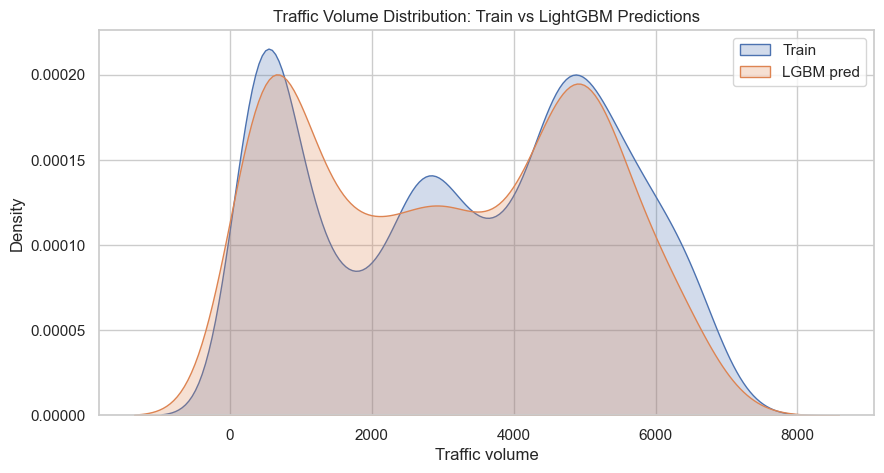

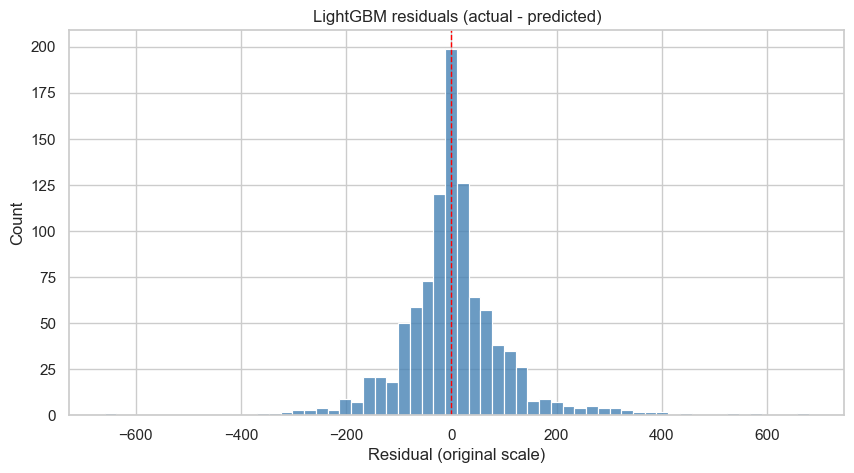

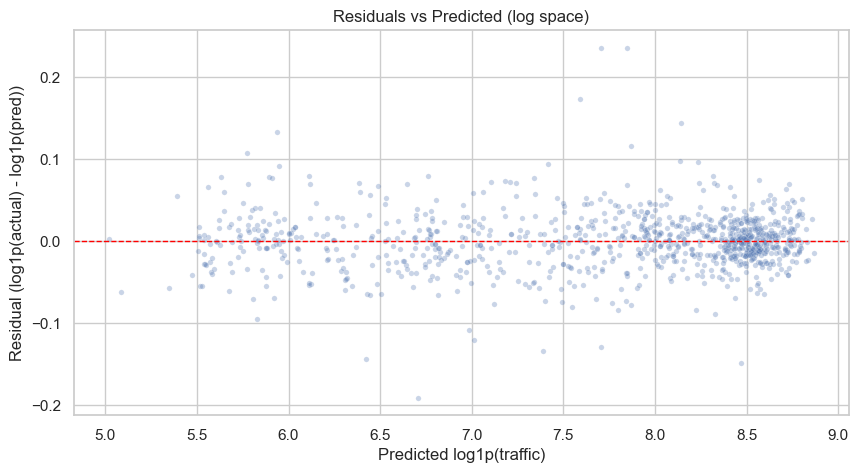

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(y_train, fill=True, alpha=0.25, label="Train", ax=ax)
sns.kdeplot(df_eval["y_pred"], fill=True, alpha=0.25, label="LGBM pred", ax=ax)
ax.set_title("Traffic Volume Distribution: Train vs LightGBM Predictions")
ax.set_xlabel("Traffic volume")
ax.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_eval["residual"], bins=60, color="steelblue", alpha=0.8)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("LightGBM residuals (actual - predicted)")
plt.xlabel("Residual (original scale)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=df_eval["y_pred_log"],
    y=df_eval["residual_log"],
    alpha=0.3,
    s=15,
)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals vs Predicted (log space)")
plt.xlabel("Predicted log1p(traffic)")
plt.ylabel("Residual (log1p(actual) - log1p(pred))")
plt.show()


### Path A: Residual Diagnostics
Probe time-of-day, weekday, and magnitude biases plus train vs prediction distribution drift to stress-test the LightGBM model.

C:\Users\jbtil\AppData\Local\Temp\ipykernel_29372\618847911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eval, x='hour', y='residual', ax=axes[0, 0], palette='Blues')
C:\Users\jbtil\AppData\Local\Temp\ipykernel_29372\618847911.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eval, x='dayofweek_num', y='residual', ax=axes[0, 1], palette='Oranges')
C:\Users\jbtil\AppData\Local\Temp\ipykernel_29372\618847911.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_eval, x='traffic_bin', y='residual', ax=axes[1,

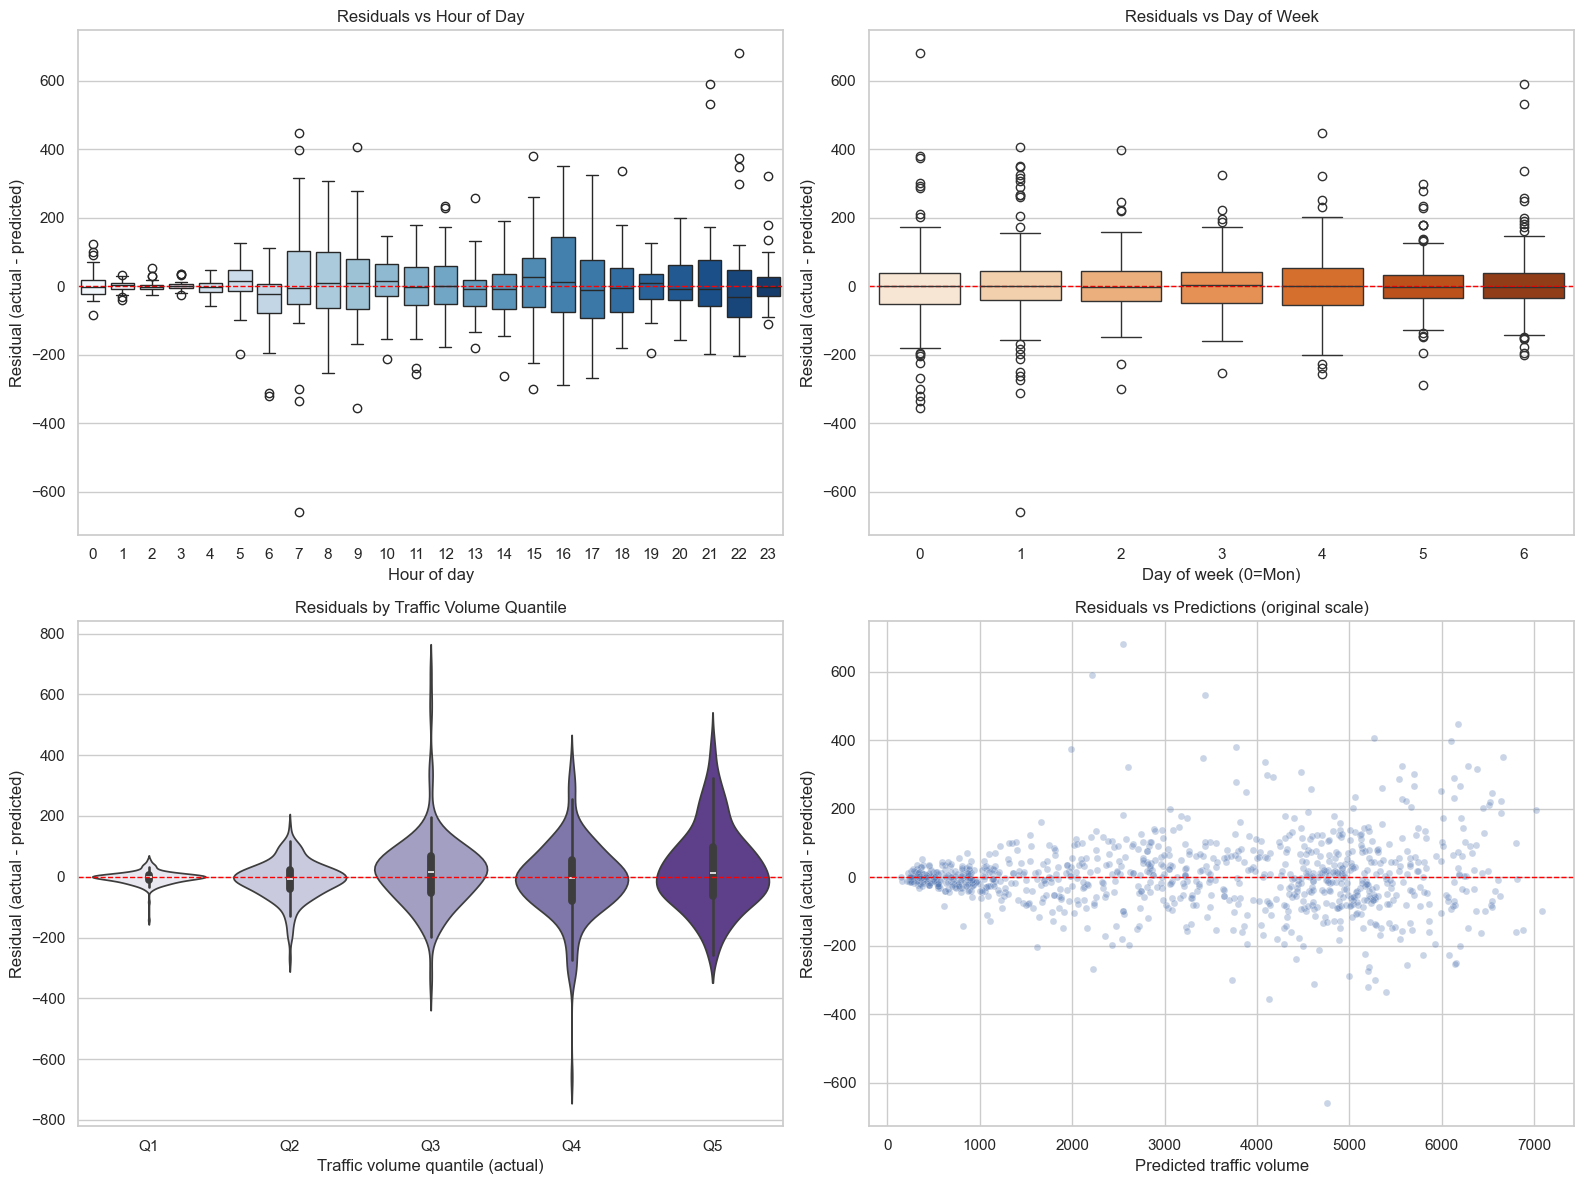

In [ ]:
if 'df_eval' not in globals():
    raise RuntimeError("df_eval not found. Run the LightGBM validation cell first.")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(data=df_eval, x='hour', y='residual', ax=axes[0, 0], palette='Blues')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals vs Hour of Day')
axes[0, 0].set_xlabel('Hour of day')
axes[0, 0].set_ylabel('Residual (actual - predicted)')

df_eval['dayofweek_num'] = df_eval['dayofweek'].astype(int)
sns.boxplot(data=df_eval, x='dayofweek_num', y='residual', ax=axes[0, 1], palette='Oranges')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_title('Residuals vs Day of Week')
axes[0, 1].set_xlabel('Day of week (0=Mon)')
axes[0, 1].set_ylabel('Residual (actual - predicted)')

quantile_labels = [f'Q{i+1}' for i in range(5)]
df_eval['traffic_bin'] = pd.qcut(df_eval['y_true'], q=5, labels=quantile_labels, duplicates='drop')
sns.violinplot(data=df_eval, x='traffic_bin', y='residual', ax=axes[1, 0], palette='Purples')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title('Residuals by Traffic Volume Quantile')
axes[1, 0].set_xlabel('Traffic volume quantile (actual)')
axes[1, 0].set_ylabel('Residual (actual - predicted)')

sns.scatterplot(data=df_eval, x='y_pred', y='residual', ax=axes[1, 1], alpha=0.3, s=25)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Residuals vs Predictions (original scale)')
axes[1, 1].set_xlabel('Predicted traffic volume')
axes[1, 1].set_ylabel('Residual (actual - predicted)')

plt.tight_layout()
plt.show()

df_eval.drop(columns=['traffic_bin', 'dayofweek_num'], inplace=True)

### Residuals vs Hour of Week
Combine scatter and boxplot views to inspect how residuals change over the 168 hour-of-week positions (0 = Monday 00:00).

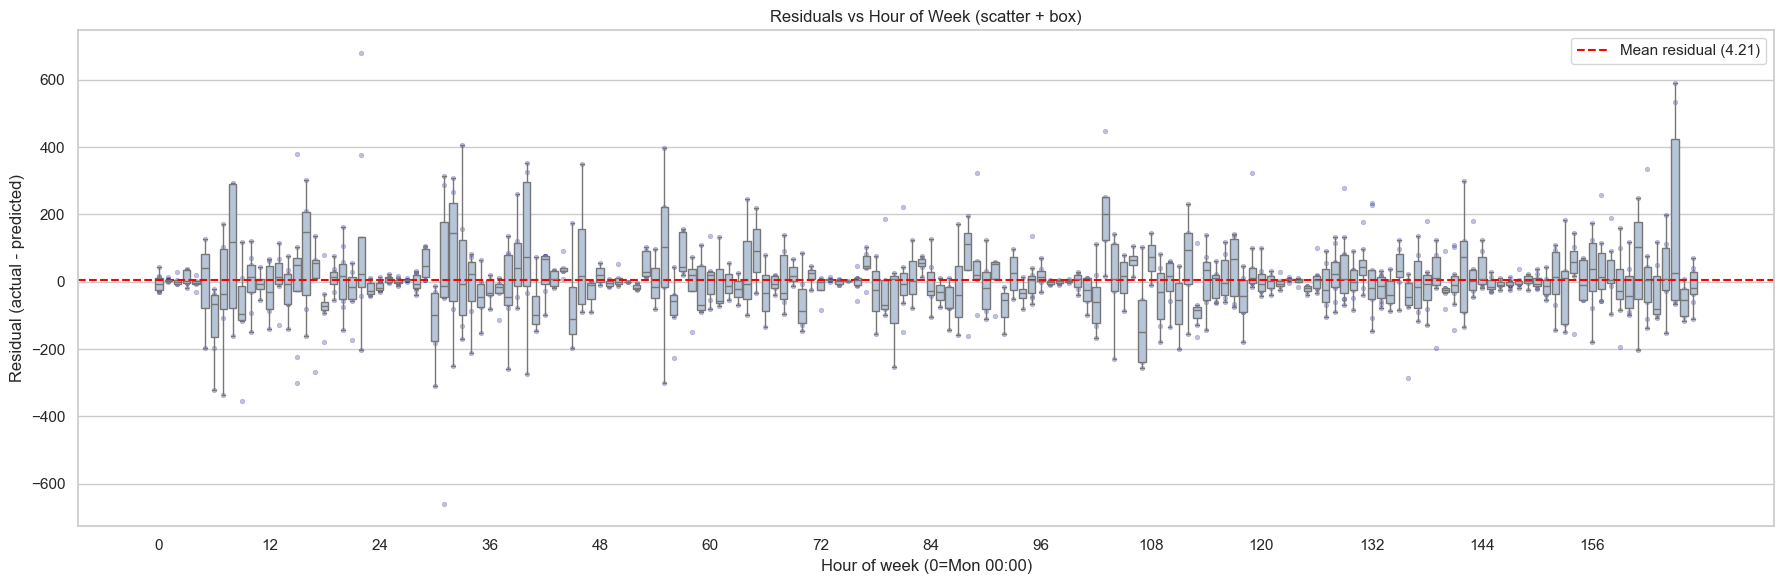

In [ ]:
if 'df_eval' not in globals():
    raise RuntimeError("df_eval not found. Run the validation diagnostics cell before plotting residuals.")

if 'hour_of_week' not in df_eval.columns:
    if {'hour', 'dayofweek_num'}.issubset(df_eval.columns):
        df_eval['hour_of_week'] = df_eval['dayofweek_num'] * 24 + df_eval['hour']
    else:
        raise RuntimeError("Unable to build 'hour_of_week' because required columns are missing.")

plot_sample = df_eval.sample(n=min(5000, len(df_eval)), random_state=42)
mean_residual = df_eval['residual'].mean()

fig, ax = plt.subplots(figsize=(18, 6))

sns.boxplot(
    data=df_eval,
    x='hour_of_week',
    y='residual',
    color='lightsteelblue',
    showfliers=False,
    ax=ax,
 )

sns.scatterplot(
    data=plot_sample,
    x='hour_of_week',
    y='residual',
    color='navy',
    edgecolor=None,
    alpha=0.25,
    s=12,
    ax=ax,
 )

ax.axhline(mean_residual, color='red', linestyle='--', linewidth=1.5, label=f"Mean residual ({mean_residual:.2f})")
ax.set_title('Residuals vs Hour of Week (scatter + box)')
ax.set_xlabel('Hour of week (0=Mon 00:00)')
ax.set_ylabel('Residual (actual - predicted)')
ax.set_xticks(np.arange(0, 168, 12))
ax.set_xticklabels([str(x) for x in np.arange(0, 168, 12)])
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### SHAP Value Analysis
Use SHAP to quantify the LightGBM feature attributions, inspect global importance, and visualize dependence/interactions for the most business-relevant predictors.

## AutoML Benchmarking & Submission Factory
This block compares a curated set of low-variance estimators, reports both log-RMSE and RMSE, and writes the best-performing submission.


[STEP 1] Building stable feature matrices with engineer_features...
Training matrix shape: (5000, 7)
Feature columns: ['hour', 'dayofweek', 'year', 'dayofyear', 'weather_final', 'temp', 'clouds_all']

[STEP 2] Running 5-fold CV (log1p target, reporting both log-RMSE and RMSE)...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 19
[LightGBM] [Info] Start training from score 7.755802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 19
[LightGBM] [Info] Start training from score 7.742839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 19
[LightGBM] [Info] Start training from score 7.744337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 19
[LightGBM] [Info] Start training from score 7.754891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 19
[LightGBM] [Info] Start training from score 7.743641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

,model,log_rmse_mean,log_rmse_std,rmse_mean,rmse_std
2,LGBM_low_var,0.138590,0.006214,357.226158,14.054886
1,HGB_medium,0.139978,0.005909,363.196852,9.380353
7,CatBoost_low_var,0.140455,0.005363,372.678701,15.468149
0,HGB_conservative,0.157927,0.006742,404.274896,11.033962
3,RF_shallow,0.487639,0.012957,1302.700595,16.293007
4,ExtraTrees_shallow,0.731940,0.013604,1778.313408,26.852846
6,ElasticNet_linear,0.924079,0.017482,2174.485830,17.997000
5,Ridge_linear,0.821633,0.015269,2212.954098,33.460375



[STEP 3] Best model by RMSE: LGBM_low_var (RMSE=357.226 ± 14.055)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 19
[LightGBM] [Info] Start training from score 7.748302
Saved AutoML submission to C:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\automl_low_variance_submission.csv


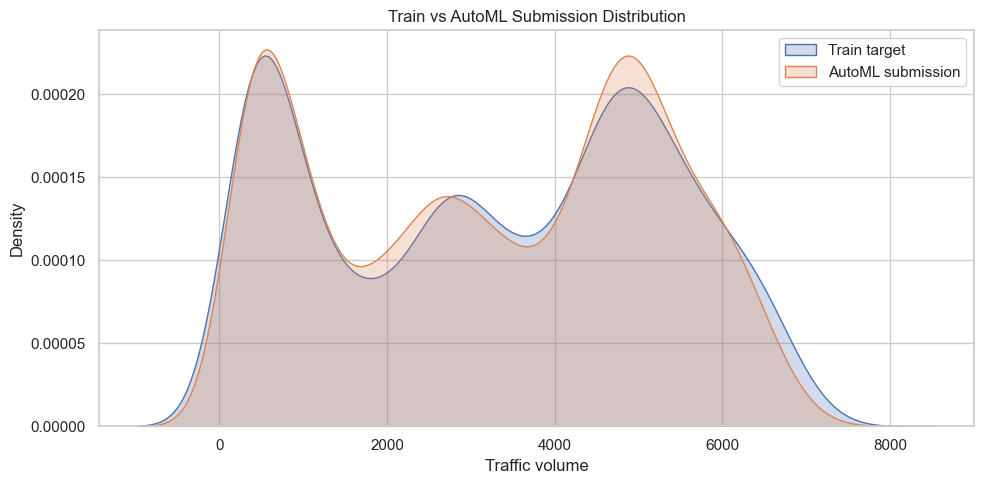

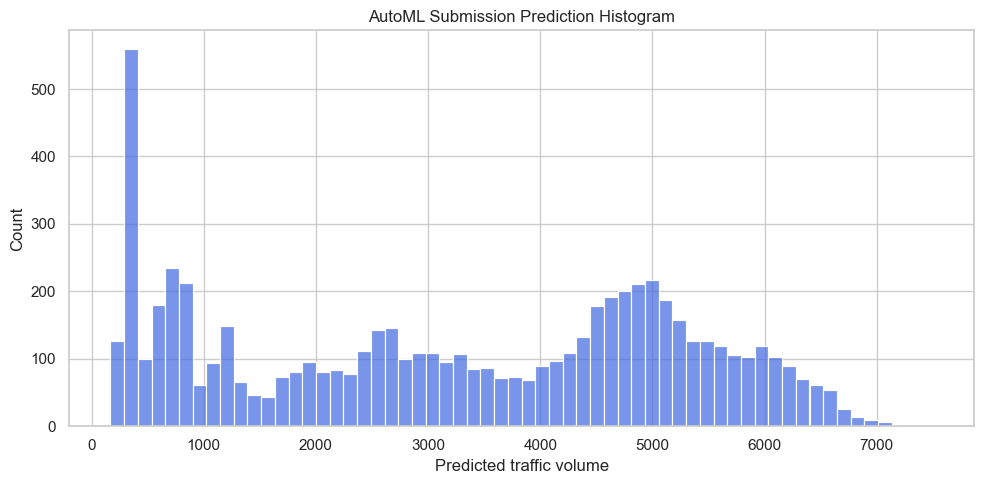

In [ ]:
# === BIG AUTOML MODEL CHECK CELL ===
# This cell:
#   1) Rebuilds the locked seven-feature matrix via engineer_features
#   2) Evaluates a compact, low-variance model zoo with 5-fold CV
#   3) Picks the best RMSE model, fits on all data, and writes a Kaggle submission
#   4) Plots train vs prediction distributions and a prediction histogram

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from feature_engineering.transformers import engineer_features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, ElasticNet
from lightgbm import LGBMRegressor

try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None

try:
    from catboost import CatBoostRegressor
except ImportError:
    CatBoostRegressor = None

sns.set_theme(style="whitegrid")

print("\n[STEP 1] Building stable feature matrices with engineer_features...")
train_features_full = build_lightgbm_frame(train_df, include_target=True)
kaggle_features_full = build_lightgbm_frame(kaggle_df, include_target=False)

categorical_cols = ["dayofweek", "weather_final"]
numeric_cols = [col for col in STABLE_FEATURES if col not in categorical_cols]

X_df = train_features_full[STABLE_FEATURES].copy()
y_array = train_features_full["traffic_volume"].to_numpy()

print(f"Training matrix shape: {X_df.shape}")
print(f"Feature columns: {STABLE_FEATURES}")

def make_preprocessor() -> ColumnTransformer:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    return ColumnTransformer(
        transformers=[
            ("categorical", onehot, categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )

def tree_pipeline(estimator):
    return Pipeline([
        ("preprocess", make_preprocessor()),
        ("model", estimator),
    ])

def linear_pipeline(estimator):
    return Pipeline([
        ("preprocess", make_preprocessor()),
        ("scaler", StandardScaler()),
        ("model", estimator),
    ])

model_builders = {
    "HGB_conservative": lambda: tree_pipeline(HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.03,
        max_leaf_nodes=31,
        max_depth=6,
        min_samples_leaf=80,
        l2_regularization=0.2,
        max_iter=400,
        random_state=42,
    )),
    "HGB_medium": lambda: tree_pipeline(HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.05,
        max_leaf_nodes=63,
        max_depth=8,
        min_samples_leaf=60,
        l2_regularization=0.1,
        max_iter=400,
        random_state=42,
    )),
    "LGBM_low_var": lambda: tree_pipeline(LGBMRegressor(
        objective="regression",
        learning_rate=0.03,
        n_estimators=800,
        num_leaves=31,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=80,
        reg_lambda=0.5,
        random_state=42,
    )),
    "RF_shallow": lambda: tree_pipeline(RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=60,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    )),
    "ExtraTrees_shallow": lambda: tree_pipeline(ExtraTreesRegressor(
        n_estimators=400,
        max_depth=10,
        min_samples_leaf=80,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
    )),
    "Ridge_linear": lambda: linear_pipeline(Ridge(alpha=5.0, random_state=42)),
    "ElasticNet_linear": lambda: linear_pipeline(ElasticNet(alpha=1.0, l1_ratio=0.3, random_state=42)),
}

if XGBRegressor is not None:
    model_builders["XGB_low_var"] = lambda: tree_pipeline(XGBRegressor(
        objective="reg:squarederror",
        learning_rate=0.03,
        n_estimators=800,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=10,
        reg_lambda=1.0,
        reg_alpha=0.5,
        tree_method="hist",
        random_state=42,
    ))

if CatBoostRegressor is not None:
    model_builders["CatBoost_low_var"] = lambda: tree_pipeline(CatBoostRegressor(
        loss_function="RMSE",
        depth=6,
        learning_rate=0.03,
        iterations=800,
        l2_leaf_reg=5.0,
        random_state=42,
        verbose=False,
    ))

print("\n[STEP 2] Running 5-fold CV (log1p target, reporting both log-RMSE and RMSE)...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_builder(name, builder, X_df, y, cv):
    log_rmses = []
    rmses = []

    for train_idx, val_idx in cv.split(X_df):
        X_train = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_train = y[train_idx]
        y_val = y[val_idx]

        model = builder()
        model.fit(X_train, np.log1p(y_train))

        y_val_pred_log = model.predict(X_val)
        y_val_pred = np.expm1(y_val_pred_log)

        log_rmse = mean_squared_error(np.log1p(y_val), y_val_pred_log, squared=False)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)

        log_rmses.append(log_rmse)
        rmses.append(rmse)

    return {
        "model": name,
        "log_rmse_mean": float(np.mean(log_rmses)),
        "log_rmse_std": float(np.std(log_rmses)),
        "rmse_mean": float(np.mean(rmses)),
        "rmse_std": float(np.std(rmses)),
    }

results = [evaluate_builder(name, builder, X_df, y_array, cv) for name, builder in model_builders.items()]
results_df = pd.DataFrame(results).sort_values("rmse_mean")
display(results_df)

best_row = results_df.iloc[0]
best_name = best_row["model"]
print(f"\n[STEP 3] Best model by RMSE: {best_name} (RMSE={best_row['rmse_mean']:.3f} ± {best_row['rmse_std']:.3f})")

best_pipeline = model_builders[best_name]()
best_pipeline.fit(X_df, np.log1p(y_array))

kaggle_predictions_log = best_pipeline.predict(kaggle_features_full[STABLE_FEATURES])
kaggle_predictions = np.expm1(kaggle_predictions_log)
kaggle_predictions = np.clip(kaggle_predictions, a_min=0.0, a_max=None)

kaggle_ids = kaggle_features_full.get("ID")
if kaggle_ids is None:
    kaggle_ids = pd.Series(np.arange(len(kaggle_predictions)))

automl_submission = pd.DataFrame({
    "ID": kaggle_ids,
    "traffic_volume": kaggle_predictions,
})

submission_path = Path("automl_low_variance_submission.csv")
automl_submission.to_csv(submission_path, index=False)
print(f"Saved AutoML submission to {submission_path.resolve()}")

plt.figure(figsize=(10, 5))
sns.kdeplot(train_features_full["traffic_volume"], fill=True, alpha=0.25, label="Train target")
sns.kdeplot(automl_submission["traffic_volume"], fill=True, alpha=0.25, label="AutoML submission")
plt.title("Train vs AutoML Submission Distribution")
plt.xlabel("Traffic volume")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(automl_submission["traffic_volume"], bins=60, color="royalblue", alpha=0.7)
plt.title("AutoML Submission Prediction Histogram")
plt.xlabel("Predicted traffic volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Dalex-Style Model Profile Comparison
After selecting the best RMSE models, visualize their behavior vs key temporal features to validate shape alignment.

In [35]:
# === HGB 10-FOLD ENGINEERED ENSEMBLE (NO TIME-SERIES SPLITS) ===
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from feature_engineering.transformers import engineer_features

STABLE_FEATURES = [
    "hour",
    "dayofweek",
    "year",
    "dayofyear",
    "temp",
]

# -------------------------------------------------------------------
# Paths for artifacts
# -------------------------------------------------------------------
ARTIFACTS = Path.cwd() / "artifacts_hgb_engineered_10fold"
ARTIFACTS.mkdir(exist_ok=True)

SUBMISSION_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold.csv"
METRICS_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_metrics.json"

# -------------------------------------------------------------------
# Base model params (exactly as requested)
# -------------------------------------------------------------------
BASE_PARAMS = dict(
    learning_rate=0.03,
    max_iter=3000,
    max_depth=18,
    max_leaf_nodes=84,
    min_samples_leaf=15,
    max_bins=160,
    l2_regularization=0.10,
    early_stopping=False,
    scoring="neg_root_mean_squared_error"
)

N_FOLDS = 10
KF_RANDOM_STATE = 2025

# -------------------------------------------------------------------
# Feature preparation using engineered features
# -------------------------------------------------------------------
def _ensure_datetime(series: pd.Series) -> pd.Series:
    if series.dtype.kind == "M":
        return series
    return pd.to_datetime(series, utc=False, errors="coerce")


def build_engineered_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    """Run engineer_features and attach auxiliary fields needed downstream."""
    engineered = engineer_features(df_in)
    frame = engineered.copy()

    frame["dayofweek"] = frame["dayofweek"].astype("category")
    frame["weather_final"] = frame["weather_final"].astype("category")

    if "traffic_volume" in df_in.columns:
        traffic = df_in["traffic_volume"].astype(float)
        frame["traffic_volume"] = traffic.values
        frame["traffic_volume_log"] = np.log1p(traffic).values

    if "ID" in df_in.columns:
        frame["ID"] = df_in["ID"].values

    if "date_time" in df_in.columns:
        dt = _ensure_datetime(df_in["date_time"])
        frame["date_time"] = dt
        frame["time_index"] = (dt - dt.min()).dt.total_seconds() / 3600.0
    else:
        frame["time_index"] = np.arange(len(frame), dtype=float)

    frame["dayofweek_numeric"] = frame["dayofweek"].astype(str).astype(int)
    frame["day_of_week"] = frame["dayofweek_numeric"]
    frame["hour_of_week"] = frame["dayofweek_numeric"] * 24 + frame["hour"]

    return frame.sort_values("time_index").reset_index(drop=True)


def build_X_y(train_eng: pd.DataFrame):
    """Split engineered train frame into X, y using the locked feature set."""
    if "traffic_volume" not in train_eng.columns:
        raise ValueError("Expected column 'traffic_volume' in engineered train frame.")

    X = train_eng[STABLE_FEATURES].copy()
    y = train_eng["traffic_volume"].astype(float)

    return X, y


def build_kaggle_X(kaggle_eng: pd.DataFrame, train_X_columns: list[str]):
    """Build Kaggle feature frame matching the columns used in training."""
    Xk = kaggle_eng[STABLE_FEATURES].copy()

    for col in train_X_columns:
        if col not in Xk.columns:
            Xk[col] = 0.0

    return Xk[train_X_columns]


# -------------------------------------------------------------------
# Pipeline builder
# -------------------------------------------------------------------
def build_pipeline(features: pd.DataFrame) -> Pipeline:
    """Create preprocessing + HGB model pipeline with given BASE_PARAMS."""
    categorical_cols = features.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = [col for col in features.columns if col not in categorical_cols]

    onehot_kwargs = {"handle_unknown": "ignore"}
    import inspect
    if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
        onehot_kwargs["sparse_output"] = False
    else:
        onehot_kwargs["sparse"] = False

    transformer = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(**onehot_kwargs), categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )

    model = HistGradientBoostingRegressor(**BASE_PARAMS)

    return Pipeline([
        ("preprocessor", transformer),
        ("model", model),
    ])


# -------------------------------------------------------------------
# Main training + ensembling logic
# -------------------------------------------------------------------
def main() -> None:
    print("[HGB 10-fold] Building engineered train and Kaggle frames...")
    train_eng = build_engineered_frame(train_df)
    kaggle_eng = build_engineered_frame(kaggle_df)

    X, y = build_X_y(train_eng)
    train_X_cols = X.columns.tolist()
    X_kaggle = build_kaggle_X(kaggle_eng, train_X_cols)

    print(f"[HGB 10-fold] Training features shape: {X.shape}")
    print(f"[HGB 10-fold] Kaggle features shape: {X_kaggle.shape}")

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=KF_RANDOM_STATE)

    oof_predictions = np.zeros(len(X), dtype=float)
    prediction_counts = np.zeros(len(X), dtype=float)
    kaggle_predictions = np.zeros(X_kaggle.shape[0], dtype=float)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"[HGB 10-fold] Fold {fold}/{N_FOLDS}...")

        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        pipeline = build_pipeline(X_train_fold)

        pipeline.fit(X_train_fold, y_train_fold)

        val_preds = pipeline.predict(X_val_fold)
        oof_predictions[val_idx] += val_preds
        prediction_counts[val_idx] += 1

        fold_rmse = mean_squared_error(y_val_fold, val_preds, squared=False)
        fold_metrics.append({"fold": fold, "rmse": float(fold_rmse)})
        print(f"[HGB 10-fold] Fold {fold} RMSE: {fold_rmse:.3f}")

        kaggle_predictions += pipeline.predict(X_kaggle) / N_FOLDS

    prediction_counts[prediction_counts == 0] = 1.0
    oof_predictions /= prediction_counts

    overall_oof_rmse = float(mean_squared_error(y, oof_predictions, squared=False))
    print("[HGB 10-fold] --- Ensemble complete ---")
    print(f"[HGB 10-fold] Overall OOF RMSE: {overall_oof_rmse:.3f}")

    metrics = {
        "overall_oof_rmse": overall_oof_rmse,
        "base_model_params": BASE_PARAMS,
        "n_folds": N_FOLDS,
        "fold_metrics": fold_metrics,
        "feature_columns": train_X_cols,
    }
    METRICS_PATH.write_text(json.dumps(metrics, indent=2))
    print(f"[HGB 10-fold] Metrics saved to {METRICS_PATH}")

    np.save(ARTIFACTS / "oof_preds.npy", oof_predictions)
    np.save(ARTIFACTS / "y_true.npy", y.to_numpy())

    submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions,
    })
    submission.to_csv(SUBMISSION_PATH, index=False)
    print(f"[HGB 10-fold] Submission saved to {SUBMISSION_PATH.name}")


if __name__ == "__main__":
    main()

[HGB 10-fold] Building engineered train and Kaggle frames...
[HGB 10-fold] Training features shape: (5000, 5)
[HGB 10-fold] Kaggle features shape: (6572, 5)
[HGB 10-fold] Fold 1/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 1 RMSE: 285.236
[HGB 10-fold] Fold 2/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 2 RMSE: 286.980
[HGB 10-fold] Fold 3/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 3 RMSE: 316.145
[HGB 10-fold] Fold 4/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 4 RMSE: 292.464
[HGB 10-fold] Fold 5/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 5 RMSE: 322.004
[HGB 10-fold] Fold 6/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 6 RMSE: 356.125
[HGB 10-fold] Fold 7/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 7 RMSE: 294.066
[HGB 10-fold] Fold 8/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 8 RMSE: 294.636
[HGB 10-fold] Fold 9/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 9 RMSE: 286.084
[HGB 10-fold] Fold 10/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 10 RMSE: 285.446
[HGB 10-fold] --- Ensemble complete ---
[HGB 10-fold] Overall OOF RMSE: 302.708
[HGB 10-fold] Metrics saved to c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\artifacts_hgb_engineered_10fold\bagged_ensemble_engineered_10fold_metrics.json
[HGB 10-fold] Submission saved to bagged_ensemble_engineered_10fold.csv


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# OG model Diagnostics for biased one

In [37]:
from __future__ import annotations

import inspect
import json
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# --- Setup Logging ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
LOGGER = logging.getLogger("hgb-lean-ensemble")

# --- Artifact paths ---
ARTIFACTS = Path.cwd() / "artifacts_ensemble_LEAN"
ARTIFACTS.mkdir(exist_ok=True)
SUBMISSION_PATH = ARTIFACTS / "submission_lean_clean.csv"

# --- Parameters (Best-in-Class) ---
BASE_PARAMS = dict(
    learning_rate=0.03,
    max_iter=6000,
    max_depth=18,
    max_leaf_nodes=84,
    min_samples_leaf=15,
    max_bins=160,
    l2_regularization=0.10,
    early_stopping=False,
    scoring="neg_root_mean_squared_error",
)

# --- Ensemble controls ---

SEED_LIST = [2050, 3050, 4050, 5050, 6050, 7050]  # 60 Models

N_FOLDS = 5
ONEHOT_KWARGS = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
    ONEHOT_KWARGS["sparse_output"] = False
else:
    ONEHOT_KWARGS["sparse"] = False


def compute_sample_weights(y: pd.Series, artifacts_dir: Path) -> np.ndarray:
    """Approximate influence weights from prior OOF residuals."""
    oof_path = artifacts_dir / "oof_preds.npy"
    if oof_path.exists():
        try:
            prev_preds = np.load(oof_path)
            if prev_preds.shape[0] == len(y):
                residuals = y.values - prev_preds
                mad = np.median(np.abs(residuals)) + 1e-6
                weights = 1.0 / (1.0 + (np.abs(residuals) / mad))
                weights = np.clip(weights, 0.1, 1.0)
                LOGGER.info("Loaded influence-style weights.")
                return weights
        except Exception:
            pass
    LOGGER.info("Falling back to uniform weights.")
    return np.ones(len(y), dtype=float)


def compute_hour_of_week_bias(
    df: pd.DataFrame, y: pd.Series, artifacts_dir: Path
) -> pd.Series:
    """Compute a small, damped corrective feature per hour-of-week from prior OOF preds.

    Returns a pandas Series indexed by hour_of_week (0..167) giving a small numeric
    correction (scaled) that can be added as a feature. If no prior OOF exists,
    returns zeros.
    """
    oof_path = artifacts_dir / "oof_preds.npy"
    hour = (df["dayofweek"].astype(int) * 24 + df["hour"].astype(int)).astype(int)

    if oof_path.exists():
        try:
            prev_preds = np.load(oof_path)
            if prev_preds.shape[0] == len(y):
                # Work in original scale for residuals (more interpretable)
                true_orig = np.expm1(y.values)
                pred_orig = np.expm1(prev_preds)
                residuals = true_orig - pred_orig

                # group mean residual by hour_of_week
                df_tmp = pd.DataFrame({"hour_of_week": hour, "residual": residuals})
                mean_resid = df_tmp.groupby("hour_of_week").residual.mean()

                # damp and scale to keep feature small relative to model inputs
                scale = np.median(true_orig) + 1.0
                bias_feature = -0.5 * mean_resid / scale
                LOGGER.info("Computed hour-of-week bias feature from prior OOF.")
                return bias_feature.reindex(range(24 * 7), fill_value=0.0)
        except Exception:
            pass

    LOGGER.info("No prior OOF for hour-of-week bias; using zeros.")
    return pd.Series(0.0, index=range(24 * 7))


def compute_tail_probability(df: pd.DataFrame, y: pd.Series) -> pd.Series:
    """Estimate per-hour probability of being in the high-traffic tail.

    We compute a threshold (e.g., 99th percentile) on observed traffic and
    return for each hour_of_week the proportion of rows exceeding that threshold.
    This can be used as a feature to downweight / trim tail influence.
    """
    hour = (df["dayofweek"].astype(int) * 24 + df["hour"].astype(int)).astype(int)
    traffic_orig = np.expm1(y.values)

    try:
        threshold = np.percentile(traffic_orig, 99)
    except Exception:
        threshold = traffic_orig.max()

    df_tmp = pd.DataFrame(
        {"hour_of_week": hour, "is_tail": (traffic_orig > threshold).astype(int)}
    )
    prob = df_tmp.groupby("hour_of_week").is_tail.mean()
    return prob.reindex(range(24 * 7), fill_value=0.0)


def build_pipeline(features: pd.DataFrame, seed: int) -> Pipeline:
    model_params = BASE_PARAMS.copy()
    model_params["random_state"] = seed

    # Auto-detect categoricals
    categorical_cols = features.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    numeric_cols = [col for col in features.columns if col not in categorical_cols]

    transformer = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(**ONEHOT_KWARGS), categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )
    model = HistGradientBoostingRegressor(**model_params)
    return Pipeline([("preprocessor", transformer), ("model", model)])


def create_weather_final(df: pd.DataFrame) -> np.ndarray:
    """Re-creates the validated 8-level weather feature from raw descriptions."""
    # Clean string
    desc = df["weather_description"].str.lower()

    # Logic matches our R script exactly
    conditions = [
        desc.isin(["sky is clear", "overcast clouds"]),  # Best
        desc.isin(["few clouds", "broken clouds", "scattered clouds", "haze"]),  # Cloudy/Hazy
        desc.isin(["mist", "fog"]),  # Low Viz
        desc.isin(
            [
                "light rain",
                "drizzle",
                "light intensity drizzle",
                "light rain and snow",
                "light intensity shower rain",
            ]
        ),  # Rain Light
        desc.isin(
            [
                "moderate rain",
                "heavy intensity rain",
                "freezing rain",
                "heavy intensity drizzle",
                "shower drizzle",
                "proximity shower rain",
            ]
        ),  # Rain Mod/Heavy
        desc.isin(["light snow", "light shower snow"]),  # Snow Light
        desc.isin(["snow", "heavy snow", "sleet", "shower snow"]),  # Snow Mod/Heavy
        desc.str.contains("thunderstorm"),  # Thunderstorm
    ]

    choices = [
        "Best_Conditions",
        "Cloudy_Hazy",
        "Low_Viz",
        "Rain_Light",
        "Rain_ModHeavy",
        "Snow_Light",
        "Snow_ModHeavy",
        "Thunderstorm",
    ]

    return np.select(conditions, choices, default="Other")


def main() -> None:
    LOGGER.info("--- Loading Data ---")
    try:
        train = pd.read_csv("TRAIN_CLEAN_V2.csv")
        kaggle = pd.read_csv("KAGGLE_CLEAN_V2.csv")
    except FileNotFoundError:
        LOGGER.error("ERROR: Run v14_step1_engineer.py first.")
        return

    kaggle_ids = kaggle["ID"]

    # --- 1. CREATE WEATHER FINAL ---
    LOGGER.info("Engineering 'weather_final'...")
    train["weather_final"] = create_weather_final(train)
    kaggle["weather_final"] = create_weather_final(kaggle)

    # --- 2. THE CLEAN LIST ---
    # We select ONLY these columns. Everything else is dropped.
    keep_cols = [
        "hour",
        "dayofweek",
        "is_weekend",
        "year",
        "dayofyear",
        "month",
        "weather_final",
    ]

    X = train[keep_cols].copy()
    X_kaggle = kaggle[keep_cols].copy()

    # Ensure categoricals are strings
    for col in ["dayofweek", "month", "weather_final"]:
        X[col] = X[col].astype(str)
        X_kaggle[col] = X_kaggle[col].astype(str)

    # --- 3. THE LOG TARGET ---
    # We use the log column if it exists, or create it
    if "traffic_volume_log" in train.columns:
        y = train["traffic_volume_log"].astype(float)
    else:
        y = np.log1p(train["traffic_volume"])

    LOGGER.info(
        f"Pruned feature set. Training on {len(X.columns)} features: {list(X.columns)}"
    )

    # --- BASE ENSEMBLE (same model as v14) ---
    sample_weights = compute_sample_weights(y, ARTIFACTS)

    oof_predictions_log = np.zeros(X.shape[0])
    prediction_counts = np.zeros(X.shape[0])
    kaggle_predictions_log = np.zeros(X_kaggle.shape[0])

    LOGGER.info("--- Starting Base Ensemble Training ---")

    for seed_idx, cv_seed in enumerate(SEED_LIST, start=1):
        kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=cv_seed)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train_fold = X.iloc[train_idx]
            y_train_fold = y.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_val_fold = y.iloc[val_idx]

            fold_weights = sample_weights[train_idx]

            pipeline = build_pipeline(X_train_fold, seed=cv_seed * 100 + fold)
            pipeline.fit(
                X_train_fold,
                y_train_fold,
                model__sample_weight=fold_weights,
            )

            val_preds_log = pipeline.predict(X_val_fold)
            oof_predictions_log[val_idx] += val_preds_log
            prediction_counts[val_idx] += 1

            kaggle_fold_preds_log = pipeline.predict(X_kaggle)
            kaggle_predictions_log += kaggle_fold_preds_log / (
                N_FOLDS * len(SEED_LIST)
            )

    oof_predictions_log /= prediction_counts
    # Save base OOF so adjusted model can compute corrective features
    np.save(ARTIFACTS / "oof_preds_base.npy", oof_predictions_log)
    # also write to canonical name used by compute_sample_weights
    np.save(ARTIFACTS / "oof_preds.npy", oof_predictions_log)

    overall_rmse = np.sqrt(
        mean_squared_error(np.expm1(y), np.expm1(oof_predictions_log))
    )
    LOGGER.info("--- Base Training Complete ---")
    LOGGER.info("Base OOF RMSE (Honest Score): %.3f", overall_rmse)

    kaggle_predictions_base = np.expm1(kaggle_predictions_log)
    kaggle_predictions_base[kaggle_predictions_base < 0] = 0

    # Write base submission
    submission_base = pd.DataFrame(
        {"ID": kaggle_ids, "traffic_volume": kaggle_predictions_base}
    )
    submission_base.to_csv(SUBMISSION_PATH, index=False)
    LOGGER.info("Base submission written to %s", SUBMISSION_PATH.name)

    # --- ADJUSTED ENSEMBLE (bias-adjust + tail-trim features) ---
    LOGGER.info("Computing bias / tail features for adjusted model...")

    X_adj = X.copy()
    X_kaggle_adj = X_kaggle.copy()

    X_adj["hour_of_week"] = (
        train["dayofweek"].astype(int) * 24 + train["hour"].astype(int)
    ).astype(int)
    X_kaggle_adj["hour_of_week"] = (
        kaggle["dayofweek"].astype(int) * 24 + kaggle["hour"].astype(int)
    ).astype(int)

    # compute mapping features
    hw_bias_map = compute_hour_of_week_bias(train, y, ARTIFACTS)
    tail_prob_map = compute_tail_probability(train, y)

    # map to rows
    X_adj["hw_bias"] = X_adj["hour_of_week"].map(hw_bias_map).fillna(0.0)
    X_kaggle_adj["hw_bias"] = (
        X_kaggle_adj["hour_of_week"].map(hw_bias_map).fillna(0.0)
    )

    X_adj["tail_prob"] = X_adj["hour_of_week"].map(tail_prob_map).fillna(0.0)
    X_kaggle_adj["tail_prob"] = (
        X_kaggle_adj["hour_of_week"].map(tail_prob_map).fillna(0.0)
    )

    # Ensure categorical casting still holds
    for col in ["dayofweek", "month", "weather_final"]:
        X_adj[col] = X_adj[col].astype(str)
        X_kaggle_adj[col] = X_kaggle_adj[col].astype(str)

    # Recompute sample weights -- now compute_sample_weights will pick up base OOF we saved
    sample_weights_adj = compute_sample_weights(y, ARTIFACTS)

    oof_predictions_adj = np.zeros(X_adj.shape[0])
    prediction_counts_adj = np.zeros(X_adj.shape[0])
    kaggle_predictions_adj = np.zeros(X_kaggle_adj.shape[0])

    LOGGER.info("--- Starting Adjusted Ensemble Training ---")

    for seed_idx, cv_seed in enumerate(SEED_LIST, start=1):
        kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=cv_seed)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_adj, y)):
            X_train_fold = X_adj.iloc[train_idx]
            y_train_fold = y.iloc[train_idx]
            X_val_fold = X_adj.iloc[val_idx]
            y_val_fold = y.iloc[val_idx]

            # downweight rows that belong to the high-traffic tail
            tail_train = X_adj["tail_prob"].iloc[train_idx].values
            fold_weights = sample_weights_adj[train_idx] * (1.0 - 0.5 * tail_train)
            fold_weights = np.clip(fold_weights, 0.05, 1.0)

            pipeline = build_pipeline(
                X_train_fold, seed=cv_seed * 100 + fold + 9999
            )
            pipeline.fit(
                X_train_fold,
                y_train_fold,
                model__sample_weight=fold_weights,
            )

            val_preds_log = pipeline.predict(X_val_fold)
            oof_predictions_adj[val_idx] += val_preds_log
            prediction_counts_adj[val_idx] += 1

            kaggle_fold_preds_log = pipeline.predict(X_kaggle_adj)
            kaggle_predictions_adj += kaggle_fold_preds_log / (
                N_FOLDS * len(SEED_LIST)
            )

    oof_predictions_adj /= prediction_counts_adj

    # Save adjusted OOF
    np.save(ARTIFACTS / "oof_preds_adjusted.npy", oof_predictions_adj)

    overall_rmse_adj = np.sqrt(
        mean_squared_error(np.expm1(y), np.expm1(oof_predictions_adj))
    )
    LOGGER.info("--- Adjusted Training Complete ---")
    LOGGER.info("Adjusted OOF RMSE (Honest Score): %.3f", overall_rmse_adj)

    kaggle_predictions_adj_orig = np.expm1(kaggle_predictions_adj)
    kaggle_predictions_adj_orig[kaggle_predictions_adj_orig < 0] = 0

    # Write adjusted submission
    submission_adj_path = ARTIFACTS / "submission_bias_adjusted.csv"
    submission_adj = pd.DataFrame(
        {"ID": kaggle_ids, "traffic_volume": kaggle_predictions_adj_orig}
    )
    submission_adj.to_csv(submission_adj_path, index=False)
    LOGGER.info("Adjusted submission written to %s", submission_adj_path.name)

    # Combine base and adjusted (10/90 bias-heavy blend)
    combined = 0.1 * kaggle_predictions_base + 0.9 * kaggle_predictions_adj_orig
    combined_path = ARTIFACTS / "submission_lean_combined.csv"
    pd.DataFrame({"ID": kaggle_ids, "traffic_volume": combined}).to_csv(
        combined_path, index=False
    )
    LOGGER.info("Combined submission written to %s", combined_path.name)


if __name__ == "__main__":
    main()


2025-11-24 22:03:33,934 | INFO | --- Loading Data ---
2025-11-24 22:03:34,039 | INFO | Engineering 'weather_final'...
2025-11-24 22:03:34,059 | INFO | Pruned feature set. Training on 7 features: ['hour', 'dayofweek', 'is_weekend', 'year', 'dayofyear', 'month', 'weather_final']
2025-11-24 22:03:34,067 | INFO | Loaded influence-style weights.
2025-11-24 22:03:34,067 | INFO | --- Starting Base Ensemble Training ---


KeyboardInterrupt: 

Bilal_Version_Plot

In [38]:
# === HGB 10-FOLD ENGINEERED ENSEMBLE (NO TIME-SERIES SPLITS) ===
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from feature_engineering.transformers import engineer_features

STABLE_FEATURES = [
    "hour",
    "dayofweek",
    "year",
    "dayofyear",
    "weather_final",
    "temp",
    "clouds_all",
]

# -------------------------------------------------------------------
# Paths for artifacts
# -------------------------------------------------------------------
ARTIFACTS = Path.cwd() / "artifacts_hgb_engineered_10fold"
ARTIFACTS.mkdir(exist_ok=True)

SUBMISSION_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold.csv"
METRICS_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_metrics.json"

# -------------------------------------------------------------------
# Base model params (exactly as requested)
# -------------------------------------------------------------------
BASE_PARAMS = dict(
    learning_rate=0.03,
    max_iter=3000,
    max_depth=18,
    max_leaf_nodes=84,
    min_samples_leaf=15,
    max_bins=160,
    l2_regularization=0.10,
    early_stopping=False,
    scoring="neg_root_mean_squared_error"
)

N_FOLDS = 10
KF_RANDOM_STATE = 2025

# -------------------------------------------------------------------
# Feature preparation using engineered features
# -------------------------------------------------------------------
def _ensure_datetime(series: pd.Series) -> pd.Series:
    if series.dtype.kind == "M":
        return series
    return pd.to_datetime(series, utc=False, errors="coerce")


def build_engineered_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    """Run engineer_features and attach auxiliary fields needed downstream."""
    engineered = engineer_features(df_in)
    frame = engineered.copy()

    frame["dayofweek"] = frame["dayofweek"].astype("category")
    frame["weather_final"] = frame["weather_final"].astype("category")

    if "traffic_volume" in df_in.columns:
        traffic = df_in["traffic_volume"].astype(float)
        frame["traffic_volume"] = traffic.values
        frame["traffic_volume_log"] = np.log1p(traffic).values

    if "ID" in df_in.columns:
        frame["ID"] = df_in["ID"].values

    if "date_time" in df_in.columns:
        dt = _ensure_datetime(df_in["date_time"])
        frame["date_time"] = dt
        frame["time_index"] = (dt - dt.min()).dt.total_seconds() / 3600.0
    else:
        frame["time_index"] = np.arange(len(frame), dtype=float)

    frame["dayofweek_numeric"] = frame["dayofweek"].astype(str).astype(int)
    frame["day_of_week"] = frame["dayofweek_numeric"]
    frame["hour_of_week"] = frame["dayofweek_numeric"] * 24 + frame["hour"]

    return frame.sort_values("time_index").reset_index(drop=True)


def build_X_y(train_eng: pd.DataFrame):
    """Split engineered train frame into X, y using the locked feature set."""
    if "traffic_volume" not in train_eng.columns:
        raise ValueError("Expected column 'traffic_volume' in engineered train frame.")

    X = train_eng[STABLE_FEATURES].copy()
    y = train_eng["traffic_volume"].astype(float)

    return X, y


def build_kaggle_X(kaggle_eng: pd.DataFrame, train_X_columns: list[str]):
    """Build Kaggle feature frame matching the columns used in training."""
    Xk = kaggle_eng[STABLE_FEATURES].copy()

    for col in train_X_columns:
        if col not in Xk.columns:
            Xk[col] = 0.0

    return Xk[train_X_columns]


# -------------------------------------------------------------------
# Pipeline builder
# -------------------------------------------------------------------
def build_pipeline(features: pd.DataFrame) -> Pipeline:
    """Create preprocessing + HGB model pipeline with given BASE_PARAMS."""
    categorical_cols = features.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = [col for col in features.columns if col not in categorical_cols]

    onehot_kwargs = {"handle_unknown": "ignore"}
    import inspect
    if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
        onehot_kwargs["sparse_output"] = False
    else:
        onehot_kwargs["sparse"] = False

    transformer = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(**onehot_kwargs), categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )

    model = HistGradientBoostingRegressor(**BASE_PARAMS)

    return Pipeline([
        ("preprocessor", transformer),
        ("model", model),
    ])


# -------------------------------------------------------------------
# Main training + ensembling logic
# -------------------------------------------------------------------
def main() -> None:
    print("[HGB 10-fold] Building engineered train and Kaggle frames...")
    train_eng = build_engineered_frame(train_df)
    kaggle_eng = build_engineered_frame(kaggle_df)

    X, y = build_X_y(train_eng)
    train_X_cols = X.columns.tolist()
    X_kaggle = build_kaggle_X(kaggle_eng, train_X_cols)

    print(f"[HGB 10-fold] Training features shape: {X.shape}")
    print(f"[HGB 10-fold] Kaggle features shape: {X_kaggle.shape}")

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=KF_RANDOM_STATE)

    oof_predictions = np.zeros(len(X), dtype=float)
    prediction_counts = np.zeros(len(X), dtype=float)
    kaggle_predictions = np.zeros(X_kaggle.shape[0], dtype=float)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"[HGB 10-fold] Fold {fold}/{N_FOLDS}...")

        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        pipeline = build_pipeline(X_train_fold)

        pipeline.fit(X_train_fold, y_train_fold)

        val_preds = pipeline.predict(X_val_fold)
        oof_predictions[val_idx] += val_preds
        prediction_counts[val_idx] += 1

        fold_rmse = mean_squared_error(y_val_fold, val_preds, squared=False)
        fold_metrics.append({"fold": fold, "rmse": float(fold_rmse)})
        print(f"[HGB 10-fold] Fold {fold} RMSE: {fold_rmse:.3f}")

        kaggle_predictions += pipeline.predict(X_kaggle) / N_FOLDS

    prediction_counts[prediction_counts == 0] = 1.0
    oof_predictions /= prediction_counts

    overall_oof_rmse = float(mean_squared_error(y, oof_predictions, squared=False))
    print("[HGB 10-fold] --- Ensemble complete ---")
    print(f"[HGB 10-fold] Overall OOF RMSE: {overall_oof_rmse:.3f}")

    metrics = {
        "overall_oof_rmse": overall_oof_rmse,
        "base_model_params": BASE_PARAMS,
        "n_folds": N_FOLDS,
        "fold_metrics": fold_metrics,
        "feature_columns": train_X_cols,
    }
    METRICS_PATH.write_text(json.dumps(metrics, indent=2))
    print(f"[HGB 10-fold] Metrics saved to {METRICS_PATH}")

    np.save(ARTIFACTS / "oof_preds.npy", oof_predictions)
    np.save(ARTIFACTS / "y_true.npy", y.to_numpy())

    submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions,
    })
    submission.to_csv(SUBMISSION_PATH, index=False)
    print(f"[HGB 10-fold] Submission saved to {SUBMISSION_PATH.name}")


if __name__ == "__main__":
    main()

[HGB 10-fold] Building engineered train and Kaggle frames...
[HGB 10-fold] Training features shape: (5000, 7)
[HGB 10-fold] Kaggle features shape: (6572, 7)
[HGB 10-fold] Fold 1/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 1 RMSE: 280.887
[HGB 10-fold] Fold 2/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 2 RMSE: 289.168
[HGB 10-fold] Fold 3/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 3 RMSE: 307.312
[HGB 10-fold] Fold 4/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 4 RMSE: 290.687
[HGB 10-fold] Fold 5/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 5 RMSE: 335.469
[HGB 10-fold] Fold 6/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 6 RMSE: 365.884
[HGB 10-fold] Fold 7/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 7 RMSE: 299.803
[HGB 10-fold] Fold 8/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 8 RMSE: 283.916
[HGB 10-fold] Fold 9/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 9 RMSE: 290.163
[HGB 10-fold] Fold 10/10...


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HGB 10-fold] Fold 10 RMSE: 278.161
[HGB 10-fold] --- Ensemble complete ---
[HGB 10-fold] Overall OOF RMSE: 303.303
[HGB 10-fold] Metrics saved to c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\artifacts_hgb_engineered_10fold\bagged_ensemble_engineered_10fold_metrics.json
[HGB 10-fold] Submission saved to bagged_ensemble_engineered_10fold.csv


c:\Users\jbtil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Come back to this analysis -> Check the OTHER MODEL it's blending with, MIGHT be the issue IN FULL, just need an adjustment of around .05. CHECK BILAL'S CODE JUST COPY

[Diag] Loading OOF predictions and engineered train frame...
           y_true   y_pred_oof     residual
mean  3270.000000  3269.654391     0.345609
std   2036.125494  2011.596575   303.332757
min    151.000000   -88.623800 -2423.917339
max   7241.000000  7204.380269  2417.031325


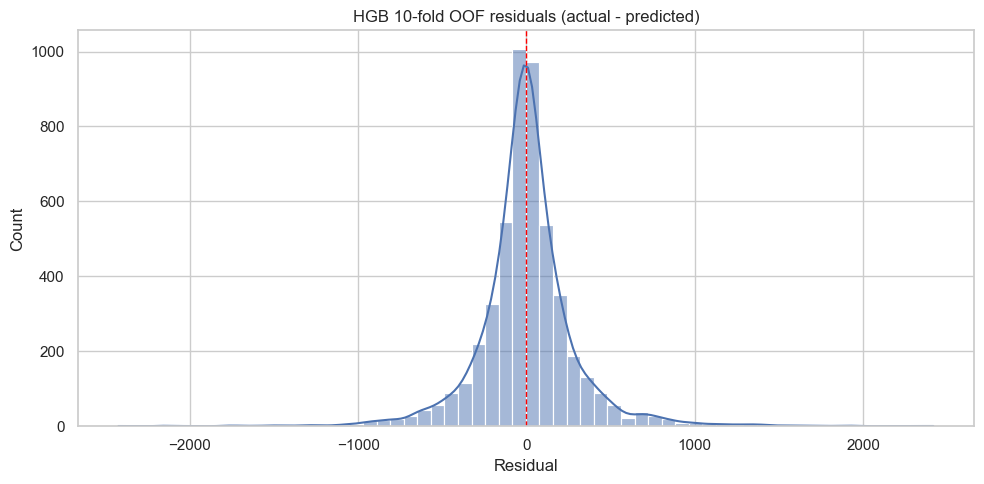

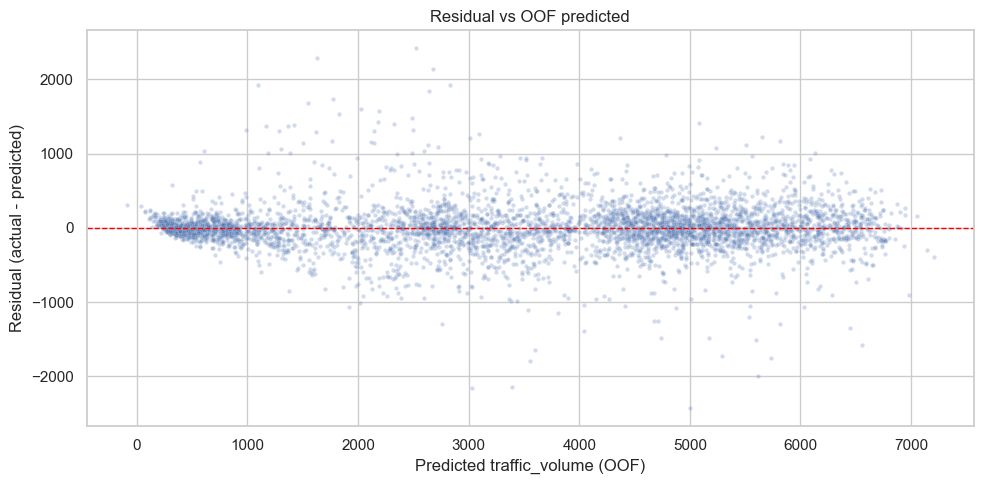

2025-11-24 22:07:19,502 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-24 22:07:19,507 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


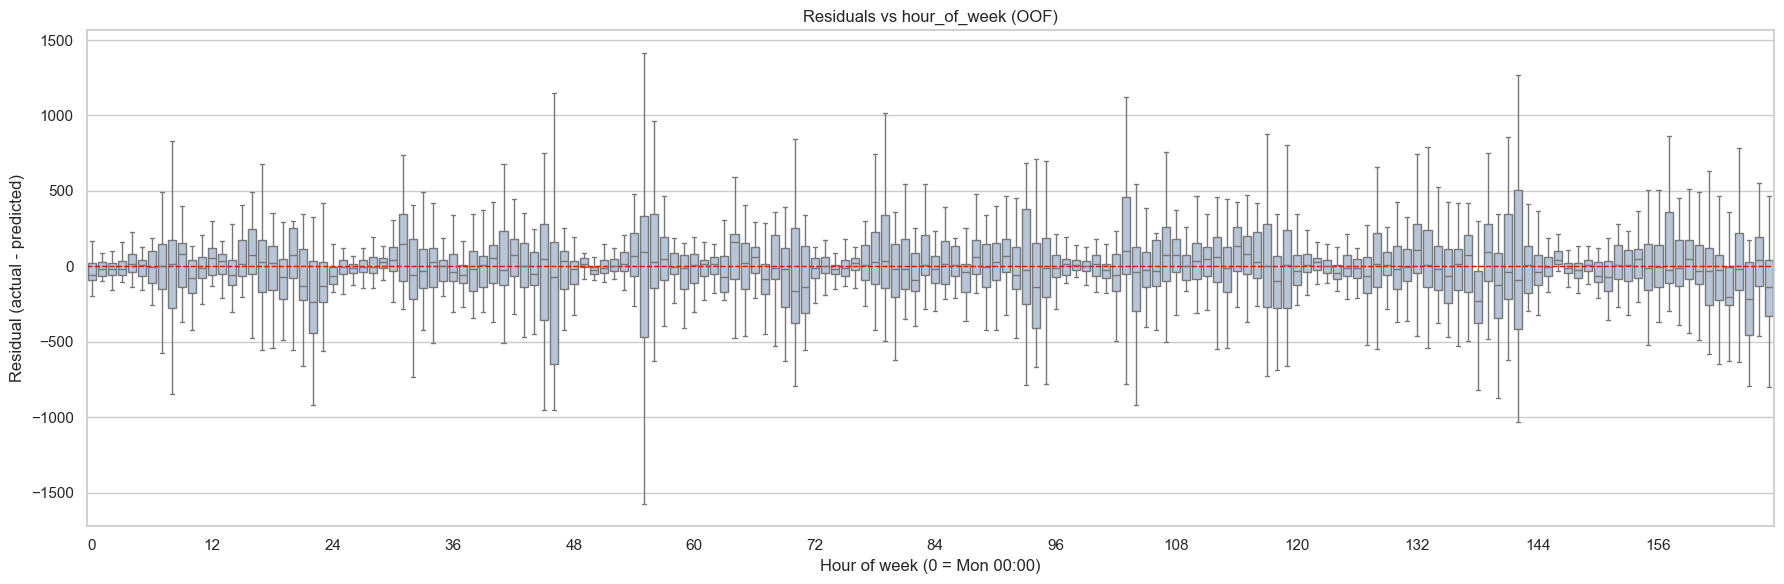

C:\Users\jbtil\AppData\Local\Temp\ipykernel_29372\1677373995.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


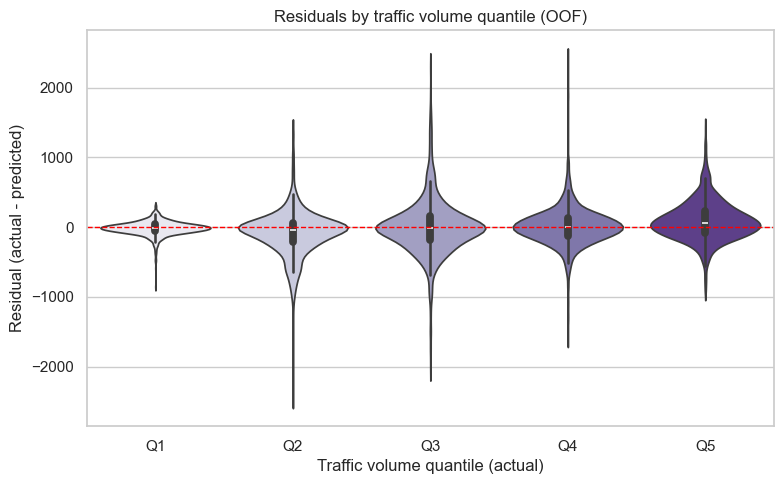

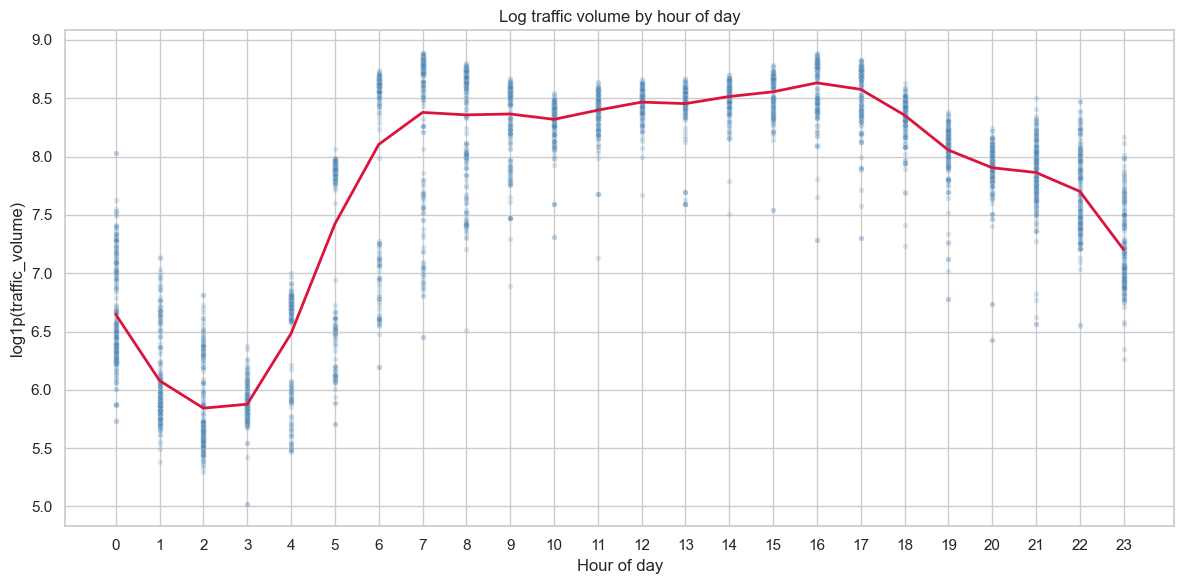

[Diag] Loading 10-fold Kaggle submission for shape check...


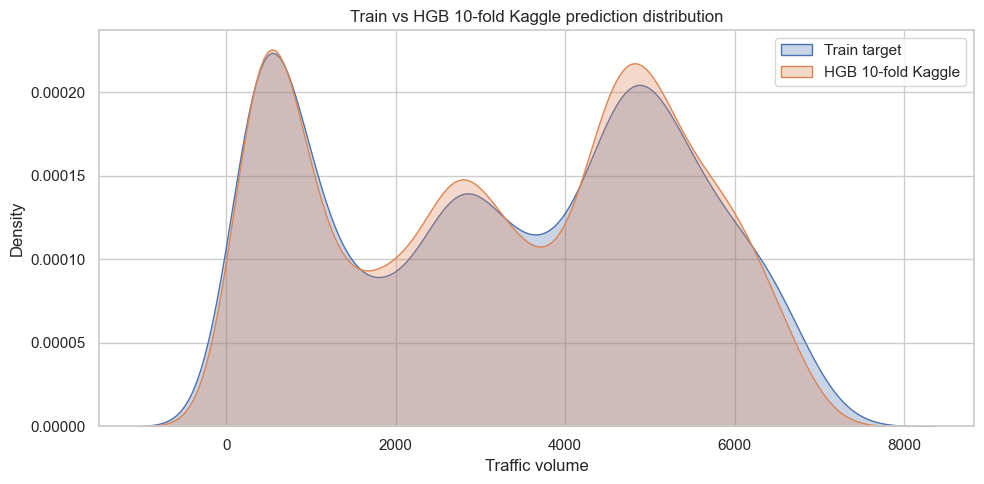

[Diag] Previous best CSV not found; checked: bagged_ensemble_submission.csv, best_model_263\bagged_ensemble_submission.csv, BEST_MODEL_261\bagged_ensemble_submission.csv


In [40]:
# === HGB 10-FOLD DIAGNOSTICS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

# Ensure artifact paths exist even if the training cell has not been run in this session
if "ARTIFACTS" not in globals():
    ARTIFACTS = Path.cwd() / "artifacts_hgb_engineered_10fold"
    ARTIFACTS.mkdir(exist_ok=True)
if "SUBMISSION_PATH" not in globals():
    SUBMISSION_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold.csv"

print("[Diag] Loading OOF predictions and engineered train frame...")

# Load OOF preds + y_true from artifacts
oof_path = ARTIFACTS / "oof_preds.npy"
ytrue_path = ARTIFACTS / "y_true.npy"

if not oof_path.exists() or not ytrue_path.exists():
    raise FileNotFoundError("Run the HGB 10-fold main() first to create OOF artifacts.")

oof_preds = np.load(oof_path)
y_true = np.load(ytrue_path)

# Rebuild engineered train frame in the same order used for X, y
train_eng_diag = build_engineered_frame(train_df).reset_index(drop=True)

if len(train_eng_diag) != len(y_true):
    raise ValueError(
        f"Length mismatch: train_eng_diag={len(train_eng_diag)}, y_true={len(y_true)}. "
        "Make sure engineer_features and X/y build use the same ordering."
    )

df_eval = train_eng_diag.copy()
df_eval["y_true"] = y_true
df_eval["y_pred_oof"] = oof_preds
df_eval["residual"] = df_eval["y_true"] - df_eval["y_pred_oof"]

print(df_eval[["y_true", "y_pred_oof", "residual"]].describe().loc[["mean", "std", "min", "max"]])

# Helper: traffic quantile binning
df_eval["traffic_bin"] = pd.qcut(
    df_eval["y_true"],
    q=5,
    labels=[f"Q{i+1}" for i in range(5)],
    duplicates="drop",
)

# -------------------------------------------------------------------
# 1. OOF residual histogram
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(df_eval["residual"], bins=60, kde=True)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("HGB 10-fold OOF residuals (actual - predicted)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 2. Residual vs predicted
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=df_eval["y_pred_oof"],
    y=df_eval["residual"],
    alpha=0.25,
    s=10,
)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residual vs OOF predicted")
plt.xlabel("Predicted traffic_volume (OOF)")
plt.ylabel("Residual (actual - predicted)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3. Residual vs hour_of_week
# -------------------------------------------------------------------
if "hour_of_week" not in df_eval.columns and {"day_of_week", "hour"}.issubset(df_eval.columns):
    df_eval["hour_of_week"] = df_eval["day_of_week"] * 24 + df_eval["hour"]

if "hour_of_week" in df_eval.columns:
    plt.figure(figsize=(18, 6))
    sns.boxplot(
        data=df_eval,
        x="hour_of_week",
        y="residual",
        color="lightsteelblue",
        showfliers=False,
    )
    plt.axhline(df_eval["residual"].mean(), color="red", linestyle="--", linewidth=1)
    plt.xticks(np.arange(0, 168, 12))
    plt.title("Residuals vs hour_of_week (OOF)")
    plt.xlabel("Hour of week (0 = Mon 00:00)")
    plt.ylabel("Residual (actual - predicted)")
    plt.tight_layout()
    plt.show()
else:
    print("[Diag] 'hour_of_week' not available for residual-by-week plot.")

# -------------------------------------------------------------------
# 4. Residuals by traffic quantile
# -------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_eval,
    x="traffic_bin",
    y="residual",
    palette="Purples",
)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals by traffic volume quantile (OOF)")
plt.xlabel("Traffic volume quantile (actual)")
plt.ylabel("Residual (actual - predicted)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 5. Log traffic volume by hour of day
# -------------------------------------------------------------------
if "hour" in df_eval.columns:
    df_eval["log_traffic_volume"] = np.log1p(df_eval["y_true"])
    hourly_log = (
        df_eval.groupby("hour", as_index=False)["log_traffic_volume"]
        .mean()
        .sort_values("hour")
    )
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df_eval,
        x="hour",
        y="log_traffic_volume",
        alpha=0.2,
        s=15,
        color="steelblue",
    )
    sns.lineplot(
        data=hourly_log,
        x="hour",
        y="log_traffic_volume",
        color="crimson",
        linewidth=2,
    )
    plt.title("Log traffic volume by hour of day")
    plt.xlabel("Hour of day")
    plt.ylabel("log1p(traffic_volume)")
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()
    df_eval.drop(columns=["log_traffic_volume"], inplace=True)
else:
    print("[Diag] 'hour' column not available for hourly log-traffic plot.")

# Clean up helper column
df_eval.drop(columns=["traffic_bin"], inplace=True)

# -------------------------------------------------------------------
# 6. Train vs new Kaggle prediction distribution
# -------------------------------------------------------------------
print("[Diag] Loading 10-fold Kaggle submission for shape check...")

sub_10fold_path = SUBMISSION_PATH  # artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold.csv
sub_10fold = pd.read_csv(sub_10fold_path)

plt.figure(figsize=(10, 5))
sns.kdeplot(df_eval["y_true"], fill=True, alpha=0.3, label="Train target")
sns.kdeplot(sub_10fold["traffic_volume"], fill=True, alpha=0.3, label="HGB 10-fold Kaggle")
plt.title("Train vs HGB 10-fold Kaggle prediction distribution")
plt.xlabel("Traffic volume")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 7. OPTIONAL: compare against your old best submission (if available)
# -------------------------------------------------------------------
candidate_prev_paths = [
    Path("bagged_ensemble_submission.csv"),
    Path("best_model_263") / "bagged_ensemble_submission.csv",
    Path("BEST_MODEL_261") / "bagged_ensemble_submission.csv",
]
best_prev_path = next((path for path in candidate_prev_paths if path.exists()), None)

if best_prev_path is not None:
    print(f"[Diag] Comparing to previous best: {best_prev_path}")
    sub_prev = pd.read_csv(best_prev_path)[["ID", "traffic_volume"]].rename(
        columns={"traffic_volume": "pred_prev_best"}
    )
    sub_new = sub_10fold[["ID", "traffic_volume"]].rename(
        columns={"traffic_volume": "pred_10fold"}
    )

    merged = sub_prev.merge(sub_new, on="ID", how="inner")
    print(f"Merged {len(merged)} rows for comparison.")

    # Correlation + scatter
    corr_val = merged[["pred_prev_best", "pred_10fold"]].corr().iloc[0, 1]
    print(f"Correlation between previous best and HGB 10-fold: {corr_val:.4f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(
        merged["pred_prev_best"],
        merged["pred_10fold"],
        alpha=0.25,
        s=5,
    )
    plt.plot(
        [merged["pred_prev_best"].min(), merged["pred_prev_best"].max()],
        [merged["pred_prev_best"].min(), merged["pred_prev_best"].max()],
        color="red",
        linestyle="--",
        label="y = x",
    )
    plt.title("Previous best vs HGB 10-fold predictions")
    plt.xlabel("Previous best prediction")
    plt.ylabel("HGB 10-fold prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Difference histogram
    merged["diff"] = merged["pred_10fold"] - merged["pred_prev_best"]
    plt.figure(figsize=(10, 5))
    sns.histplot(merged["diff"], bins=60, kde=True)
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.title("Difference: HGB 10-fold - previous best")
    plt.xlabel("Prediction difference")
    plt.tight_layout()
    plt.show()
else:
    checked_paths = ", ".join(str(path) for path in candidate_prev_paths)
    print(f"[Diag] Previous best CSV not found; checked: {checked_paths}")

[Blend] Saved blended submission -> c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\prior_best_submission\blended_263_hgb10_bias_corrected.csv


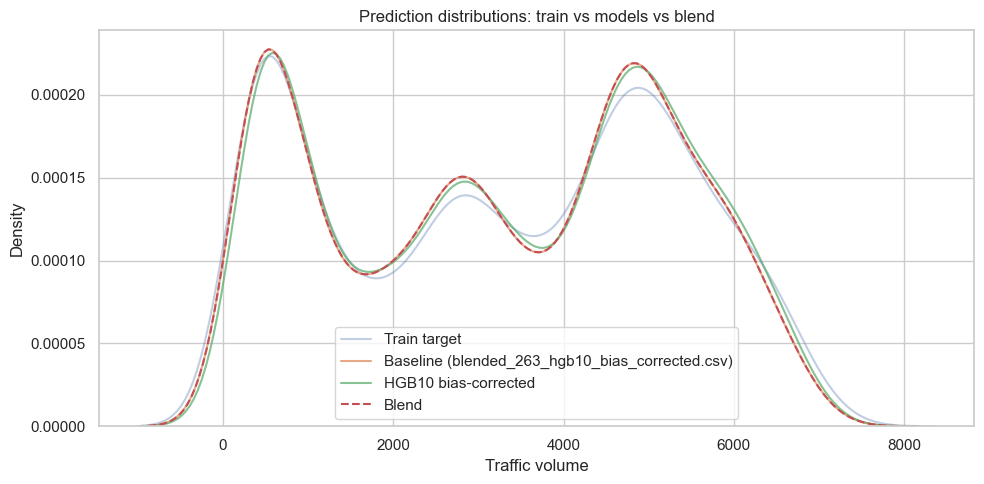

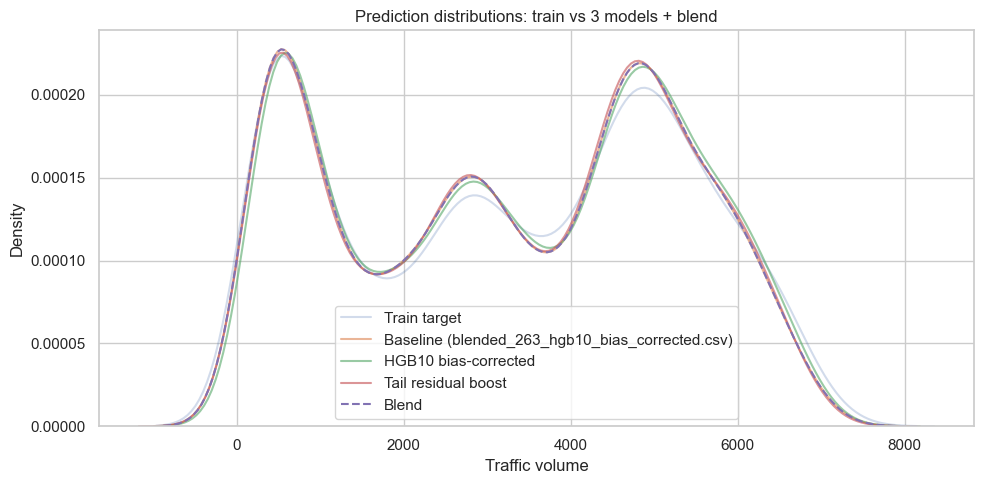

In [41]:
# === Blend old 263 model with HGB 10-fold bias-corrected ===
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

ROOT = Path.cwd()
PRIOR_BEST_DIR = ROOT / "prior_best_submission"
CANDIDATE_ARTIFACT_DIRS = [
    ROOT / "artifacts_hgb_engineered_10fold",
    ROOT.parent / "artifacts_hgb_engineered_10fold",
]

def _first_existing(paths):
    for path in paths:
        if path and path.exists():
            return path
    return None

def _discover_prior_best_csv(directory: Path) -> Path | None:
    if not directory.exists():
        return None
    csv_files = list(directory.glob("*.csv"))
    if not csv_files:
        return None
    return max(csv_files, key=lambda p: p.stat().st_mtime)

ARTIFACTS = _first_existing(CANDIDATE_ARTIFACT_DIRS)

if ARTIFACTS is None:
    print("[Blend] Skipped: artifacts_hgb_engineered_10fold directory not found.")
else:
    corrected_path = ARTIFACTS / "bagged_ensemble_engineered_10fold_bias_corrected.csv"
    tail_path = ARTIFACTS / "bagged_ensemble_engineered_10fold_tail_resid.csv"
    prior_best_path = _discover_prior_best_csv(PRIOR_BEST_DIR)
    candidate_old_paths = [
        prior_best_path,
        ROOT / "bagged_ensemble_submission.csv",
        ROOT / "BEST_MODEL_261" / "bagged_ensemble_submission.csv",
        ROOT.parent / "bagged_ensemble_submission.csv",
        ROOT.parent / "BEST_MODEL_261" / "bagged_ensemble_submission.csv",
        ROOT.parent / "best_model_263" / "bagged_ensemble_submission.csv",
    ]
    old_path = _first_existing(candidate_old_paths)

    if old_path is None:
        print("[Blend] Skipped: drop any CSV into BEST_MODEL_261/prior_best_submission/ to use it as the baseline.")
    elif not corrected_path.exists():
        print("[Blend] Skipped: corrected HGB submission is missing.")
    else:
        old_sub = pd.read_csv(old_path)
        new_sub = pd.read_csv(corrected_path)

        merged = old_sub.merge(new_sub, on="ID", suffixes=("_old", "_new"))
        if merged.empty:
            print("[Blend] Skipped: submissions do not share common IDs.")
        else:
            alpha = 0.98
            beta = 1.0 - alpha

            y_old = merged["traffic_volume_old"].to_numpy()
            y_new = merged["traffic_volume_new"].to_numpy()
            y_blend = alpha * y_old + beta * y_new

            blend_path = old_path.parent / "blended_263_hgb10_bias_corrected.csv"
            blended_sub = pd.DataFrame({
                "ID": merged["ID"],
                "traffic_volume": y_blend,
            })
            blended_sub.to_csv(blend_path, index=False)
            print("[Blend] Saved blended submission ->", blend_path)

            if "train_eng_bc" not in globals():
                train_eng_bc = build_engineered_frame(train_df).reset_index(drop=True)

            plt.figure(figsize=(10, 5))
            sns.kdeplot(train_eng_bc["traffic_volume"], label="Train target", alpha=0.35)
            sns.kdeplot(y_old, label=f"Baseline ({old_path.name})", alpha=0.7)
            sns.kdeplot(y_new, label="HGB10 bias-corrected", alpha=0.7)
            sns.kdeplot(y_blend, label="Blend", linestyle="--")
            plt.title("Prediction distributions: train vs models vs blend")
            plt.xlabel("Traffic volume")
            plt.legend()
            plt.tight_layout()
            plt.show()

            if tail_path.exists():
                tail_sub = pd.read_csv(tail_path).rename(columns={"traffic_volume": "traffic_volume_tail"})
                merged_tail = merged.merge(tail_sub, on="ID", how="inner")
                if merged_tail.empty:
                    print("[Blend] Tail submission IDs do not align with baseline/new submissions.")
                else:
                    y_tail = merged_tail["traffic_volume_tail"].to_numpy()
                    plt.figure(figsize=(10, 5))
                    sns.kdeplot(train_eng_bc["traffic_volume"], label="Train target", alpha=0.25)
                    sns.kdeplot(merged_tail["traffic_volume_old"], label=f"Baseline ({old_path.name})", alpha=0.6)
                    sns.kdeplot(merged_tail["traffic_volume_new"], label="HGB10 bias-corrected", alpha=0.6)
                    sns.kdeplot(y_tail, label="Tail residual boost", alpha=0.6)
                    sns.kdeplot(alpha * merged_tail["traffic_volume_old"] + beta * merged_tail["traffic_volume_new"], label="Blend", linestyle="--")
                    plt.title("Prediction distributions: train vs 3 models + blend")
                    plt.xlabel("Traffic volume")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"[Blend] Tail submission not found at {tail_path}")

[Shape] Using prior_best_submission CSV for plotting -> c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\prior_best_submission\blended_263_hgb10_bias_corrected.csv
[Shape] Delta vs blend -> mean: -0.72, std: 90.73, min: -126.03, max: 339.15
[Shape] Delta current vs reference -> mean: -0.72, std: 90.73
[Shape] Delta blend vs reference -> mean: 0.00, std: 0.00
[Shape] Shape-adjusted submission saved -> c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\prior_best_submission\blended_263_hgb10_bias_corrected_hourshape.csv


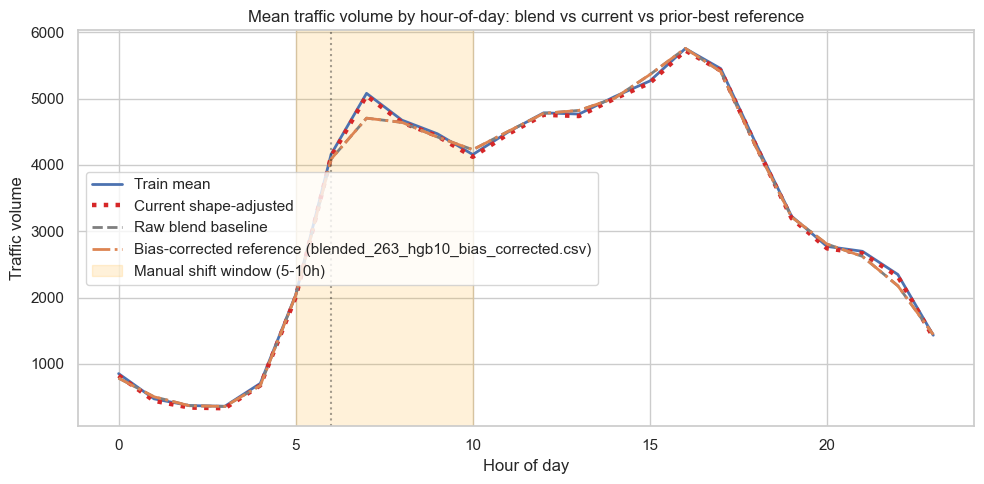

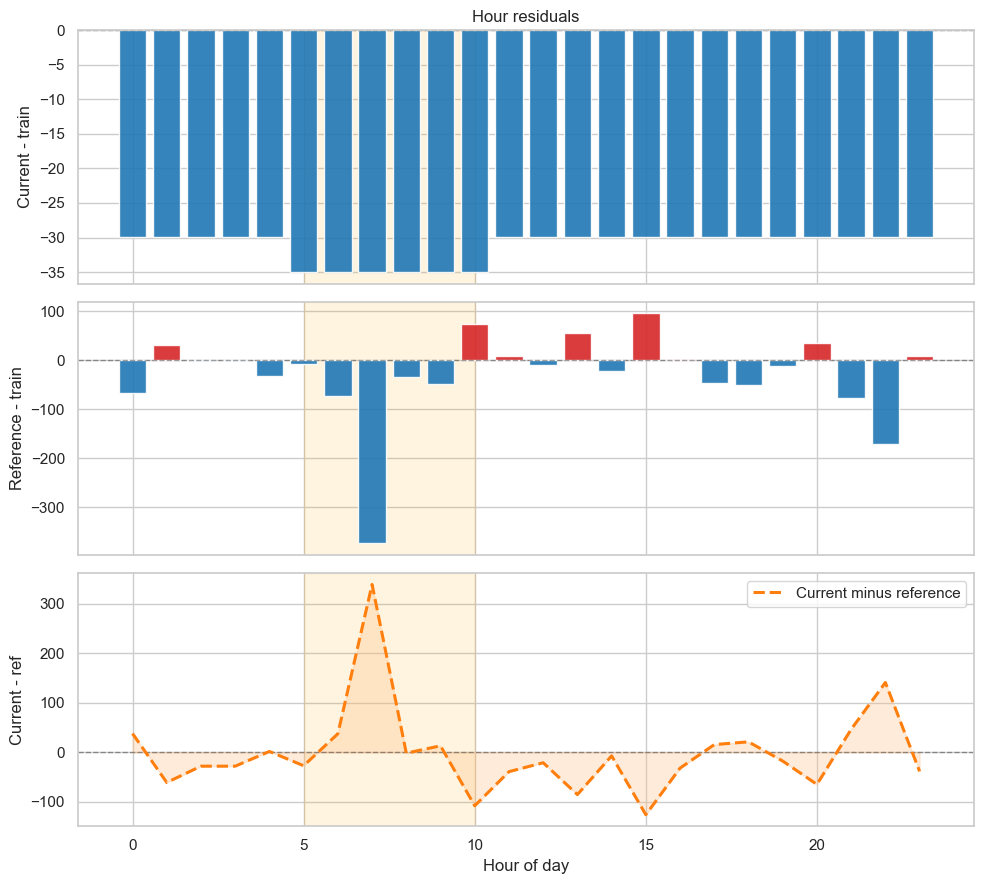

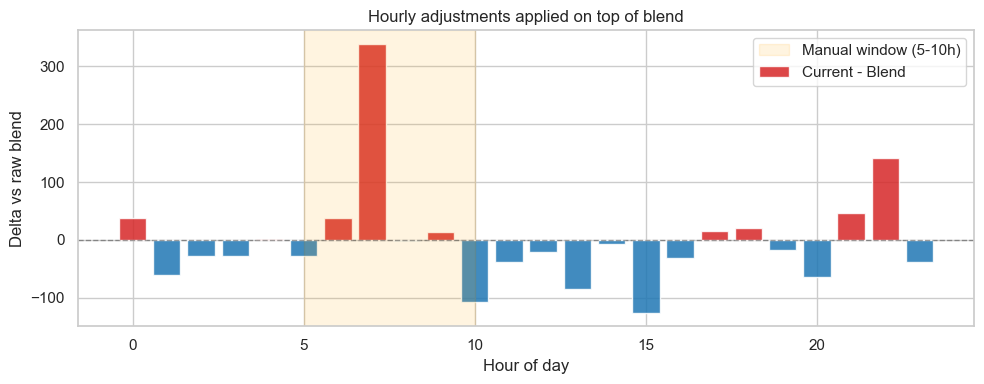

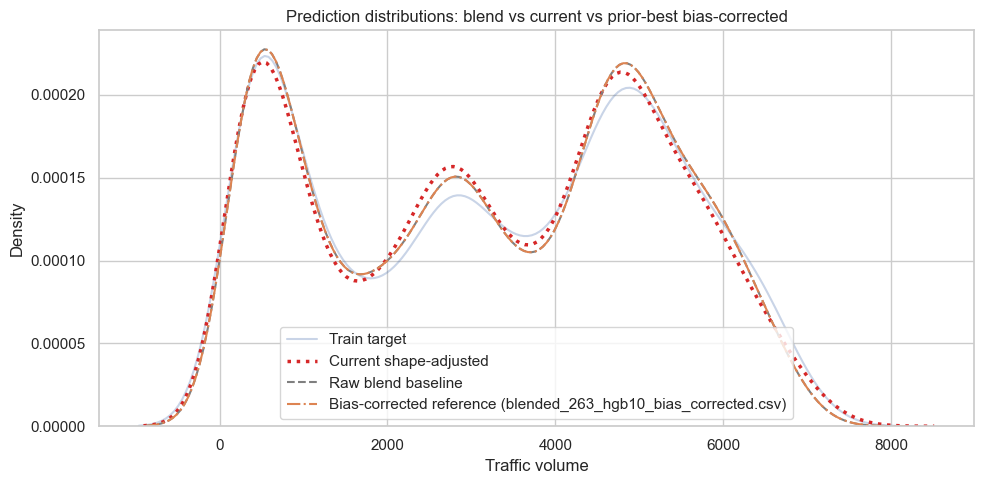

In [ ]:
# === Hour-of-day SHAPE CALIBRATOR on top of BLENDED predictions ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

if "build_engineered_frame" not in globals():
    raise RuntimeError("build_engineered_frame is not defined. Run the main HGB script first.")

train_eng_shape = build_engineered_frame(train_df).reset_index(drop=True)
kaggle_eng_shape = build_engineered_frame(kaggle_df).reset_index(drop=True)

ROOT = Path.cwd()
candidate_blend_paths = []
if "blend_path" in globals():
    candidate_blend_paths.append(Path(blend_path))
candidate_blend_paths.extend([
    ROOT / "blended_263_hgb10_bias_corrected.csv",
    ROOT / "BEST_MODEL_261" / "blended_263_hgb10_bias_corrected.csv",
    ROOT.parent / "BEST_MODEL_261" / "blended_263_hgb10_bias_corrected.csv",
])
BLEND_PATH = next((p for p in candidate_blend_paths if p.exists()), None)
if BLEND_PATH is None:
    raise FileNotFoundError("Blended submission not found. Ensure blended_263_hgb10_bias_corrected.csv exists.")

# --- reference for comparison: user-requested prior best submission ---
REFERENCE_SHAPE_PATH = None
candidate_reference_paths = [
    ROOT / "prior_best_submission" / "blended_263_hgb10_bias_corrected.csv",
    ROOT / "BEST_MODEL_261" / "prior_best_submission" / "blended_263_hgb10_bias_corrected.csv",
    ROOT.parent / "BEST_MODEL_261" / "prior_best_submission" / "blended_263_hgb10_bias_corrected.csv",
]
REFERENCE_SHAPE_PATH = next((p for p in candidate_reference_paths if p.exists()), None)

SHOW_BLEND_BASELINE = True  # toggle to visualize the raw blend alongside reference/current

blend_sub = pd.read_csv(BLEND_PATH)
if "ID" not in kaggle_eng_shape.columns:
    raise KeyError("engineer_features / build_engineered_frame must carry 'ID' for Kaggle rows.")

kaggle_shape = kaggle_eng_shape.merge(
    blend_sub.rename(columns={"traffic_volume": "traffic_volume_blend"}),
    on="ID",
    how="inner",
)
if kaggle_shape.empty:
    raise ValueError("No overlap between Kaggle engineered frame and blended submission IDs.")

if "traffic_volume" not in train_eng_shape.columns:
    raise KeyError("train_eng_shape must contain 'traffic_volume' as the true target.")

train_hour_mean = train_eng_shape.groupby("hour")["traffic_volume"].mean()
train_global_mean = train_hour_mean.mean()
blend_hour_mean = kaggle_shape.groupby("hour")["traffic_volume_blend"].mean()
blend_global_mean = blend_hour_mean.mean()
train_dev = train_hour_mean - train_global_mean
blend_dev = blend_hour_mean - blend_global_mean
shape_delta_hour = (train_dev - blend_dev).reindex(range(24)).fillna(0.0)
level_delta = float(train_global_mean - blend_global_mean)

LAMBDA_SHAPE = 0
GAMMA_LEVEL = 0

# === SIMPLE MANUAL KNOB ===
# Positive -> push up, Negative -> push down
MANUAL_SHIFT = -5   # e.g. +50.0 or -30.0

# Hour-of-day range where the manual shift applies (inclusive)
MANUAL_HOUR_MIN = 5  # e.g. 7
MANUAL_HOUR_MAX = 10 # e.g. 9
# ==========================

hour_adjust_map = LAMBDA_SHAPE * shape_delta_hour
global_adjust = GAMMA_LEVEL * level_delta

kaggle_shape["traffic_volume_shape"] = (
    kaggle_shape["traffic_volume_blend"]
    + kaggle_shape["hour"].map(hour_adjust_map).fillna(0.0)
    + global_adjust
)

# === APPLY SIMPLE MANUAL KNOB (hour range only) ===
mask_manual = kaggle_shape["hour"].between(MANUAL_HOUR_MIN, MANUAL_HOUR_MAX)
kaggle_shape.loc[mask_manual, "traffic_volume_shape"] += MANUAL_SHIFT
# =================================================
kaggle_shape["traffic_volume_shape"] = kaggle_shape["traffic_volume_shape"].clip(lower=0.0)

reference_col = None
reference_label = ""
if REFERENCE_SHAPE_PATH is not None:
    shape_ref = pd.read_csv(REFERENCE_SHAPE_PATH).rename(
        columns={"traffic_volume": "traffic_volume_shape_reference"},
    )
    kaggle_shape = kaggle_shape.merge(
        shape_ref,
        on="ID",
        how="left",
    )
    if kaggle_shape["traffic_volume_shape_reference"].isna().any():
        raise ValueError(
            "[Shape] Reference CSV missing predictions for some Kaggle rows; ensure IDs align.",
        )
    reference_col = "traffic_volume_shape_reference"
    reference_label = f"Bias-corrected reference ({REFERENCE_SHAPE_PATH.name})"
    print(f"[Shape] Using prior_best_submission CSV for plotting -> {REFERENCE_SHAPE_PATH}")
else:
    print("[Shape] Reference CSV in prior_best_submission not found; plotting current + blend only.")

# --- diagnostics to confirm we're shaping the blend, not the reference ---
blend_vs_shape = kaggle_shape["traffic_volume_shape"] - kaggle_shape["traffic_volume_blend"]
print(
    f"[Shape] Delta vs blend -> mean: {blend_vs_shape.mean():.2f}, "
    f"std: {blend_vs_shape.std():.2f}, min: {blend_vs_shape.min():.2f}, max: {blend_vs_shape.max():.2f}"
)
if reference_col is not None:
    ref_vs_shape = kaggle_shape["traffic_volume_shape"] - kaggle_shape[reference_col]
    ref_vs_blend = kaggle_shape["traffic_volume_blend"] - kaggle_shape[reference_col]
    print(
        f"[Shape] Delta current vs reference -> mean: {ref_vs_shape.mean():.2f}, "
        f"std: {ref_vs_shape.std():.2f}"
    )
    print(
        f"[Shape] Delta blend vs reference -> mean: {ref_vs_blend.mean():.2f}, "
        f"std: {ref_vs_blend.std():.2f}"
    )

SHAPE_SUB_PATH = BLEND_PATH.with_name(BLEND_PATH.stem + "_hourshape.csv")
shape_submission = kaggle_shape[["ID", "traffic_volume_shape"]].rename(
    columns={"traffic_volume_shape": "traffic_volume"}
)
shape_submission.to_csv(SHAPE_SUB_PATH, index=False)
print(f"[Shape] Shape-adjusted submission saved -> {SHAPE_SUB_PATH}")

plot_columns = ["traffic_volume_shape"]
if SHOW_BLEND_BASELINE:
    plot_columns.append("traffic_volume_blend")
if reference_col is not None:
    plot_columns.append(reference_col)
hour_profile = (
    kaggle_shape.groupby("hour")[plot_columns].mean().reset_index()
)
hour_profile = hour_profile.merge(
    train_hour_mean.rename("train_mean").reset_index(),
    on="hour",
    how="left",
)

plt.figure(figsize=(10, 5))
plt.plot(hour_profile["hour"], hour_profile["train_mean"], label="Train mean", linewidth=2)
plt.plot(
    hour_profile["hour"],
    hour_profile["traffic_volume_shape"],
    label="Current shape-adjusted",
    linestyle=":",
    linewidth=3.2,
    color="#d62728",
)
if SHOW_BLEND_BASELINE:
    plt.plot(
        hour_profile["hour"],
        hour_profile["traffic_volume_blend"],
        label="Raw blend baseline",
        linestyle="--",
        linewidth=2,
        color="#7f7f7f",
    )
if reference_col is not None:
    plt.plot(
        hour_profile["hour"],
        hour_profile[reference_col],
        label=reference_label,
        linestyle="-.",
        linewidth=2,
    )
if MANUAL_HOUR_MIN <= MANUAL_HOUR_MAX:
    highlight_label = f"Manual shift window ({MANUAL_HOUR_MIN}-{MANUAL_HOUR_MAX}h)"
    plt.axvspan(
        MANUAL_HOUR_MIN,
        MANUAL_HOUR_MAX,
        color="orange",
        alpha=0.15,
        label=highlight_label,
    )
plt.axvline(6, color="k", linestyle=":", alpha=0.4)
plt.xlabel("Hour of day")
plt.ylabel("Traffic volume")
plt.title("Mean traffic volume by hour-of-day: blend vs current vs prior-best reference")
plt.legend()
plt.tight_layout()
plt.show()

# === RESIDUAL PLOT: (pred hour mean - train hour mean) ===
resid_df = pd.DataFrame({
    "hour": hour_profile["hour"],
    "resid_current": hour_profile["traffic_volume_shape"] - hour_profile["train_mean"],
})

if reference_col is not None:
    resid_df["resid_reference"] = hour_profile[reference_col] - hour_profile["train_mean"]
    resid_df["resid_delta_cur_minus_ref"] = resid_df["resid_current"] - resid_df["resid_reference"]

n_rows = 1 if reference_col is None else 3
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3 * n_rows), sharex=True)
axes = np.atleast_1d(axes)

pos_color = "#d62728"
neg_color = "#1f77b4"

for ax in axes:
    ax.axhline(0, color="k", linestyle="--", alpha=0.4, linewidth=1)
    if MANUAL_HOUR_MIN <= MANUAL_HOUR_MAX:
        ax.axvspan(
            MANUAL_HOUR_MIN,
            MANUAL_HOUR_MAX,
            color="orange",
            alpha=0.12,
        )

axes[0].bar(
    resid_df["hour"],
    resid_df["resid_current"],
    color=np.where(resid_df["resid_current"] >= 0, pos_color, neg_color),
    alpha=0.9,
)
axes[0].set_ylabel("Current - train")
axes[0].set_title("Hour residuals")

if reference_col is not None:
    axes[1].bar(
        resid_df["hour"],
        resid_df["resid_reference"],
        color=np.where(resid_df["resid_reference"] >= 0, pos_color, neg_color),
        alpha=0.9,
    )
    axes[1].set_ylabel("Reference - train")

    axes[2].plot(
        resid_df["hour"],
        resid_df["resid_delta_cur_minus_ref"],
        label="Current minus reference",
        linestyle="--",
        linewidth=2.2,
        color="#ff7f0e",
    )
    axes[2].fill_between(
        resid_df["hour"],
        resid_df["resid_delta_cur_minus_ref"],
        0,
        color="#ffbf86",
        alpha=0.3,
    )
    axes[2].set_ylabel("Current - ref")
    axes[2].legend(loc="upper right")
    axes[-1].set_xlabel("Hour of day")
else:
    axes[0].set_xlabel("Hour of day")

plt.tight_layout()
plt.show()

# === DELTA VS BLEND BAR VIEW (how much shape moves each hour) ===
if SHOW_BLEND_BASELINE:
    delta_df = pd.DataFrame({
        "hour": hour_profile["hour"],
        "delta_current_vs_blend": hour_profile["traffic_volume_shape"] - hour_profile["traffic_volume_blend"],
    })
    colors = np.where(delta_df["delta_current_vs_blend"] >= 0, "#d62728", "#1f77b4")
    all_zero = np.isclose(delta_df["delta_current_vs_blend"], 0.0).all()

    plt.figure(figsize=(10, 4))
    plt.axhline(0, color="k", linestyle="--", alpha=0.4, linewidth=1)
    plt.bar(
        delta_df["hour"],
        delta_df["delta_current_vs_blend"],
        color=colors,
        alpha=0.85,
        label="Current - Blend",
    )
    if all_zero:
        plt.text(
            0.5,
            0.5,
            "No adjustments vs blend (all deltas = 0)",
            transform=plt.gca().transAxes,
            ha="center",
            va="center",
            fontsize=11,
            color="#555555",
        )
    if MANUAL_HOUR_MIN <= MANUAL_HOUR_MAX:
        plt.axvspan(
            MANUAL_HOUR_MIN,
            MANUAL_HOUR_MAX,
            color="orange",
            alpha=0.12,
            label=f"Manual window ({MANUAL_HOUR_MIN}-{MANUAL_HOUR_MAX}h)",
        )
    plt.xlabel("Hour of day")
    plt.ylabel("Delta vs raw blend")
    plt.title("Hourly adjustments applied on top of blend")
    plt.legend()
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 5))
sns.kdeplot(train_eng_shape["traffic_volume"], label="Train target", alpha=0.3)
sns.kdeplot(
    kaggle_shape["traffic_volume_shape"],
    label="Current shape-adjusted",
    linestyle=":",
    linewidth=2.5,
    color="#d62728",
)
if SHOW_BLEND_BASELINE:
    sns.kdeplot(
        kaggle_shape["traffic_volume_blend"],
        label="Raw blend baseline",
        linestyle="--",
        color="#7f7f7f",
    )
if reference_col is not None:
    sns.kdeplot(
        kaggle_shape[reference_col],
        label=reference_label,
        linestyle="-.",
    )
plt.xlabel("Traffic volume")
plt.title("Prediction distributions: blend vs current vs prior-best bias-corrected")
plt.legend()
plt.tight_layout()
plt.show()

# Double check later

# Isweekend (0,1 binary), dayofyear (out of 365), (7) Across week variation (Check Temperature for overfitting, possible remove OR split into bins) Heavy snow heavy intensity rain 

* Temp by year by traffic volume plot 

[Blend] Saved blended submission -> blended_263_hgb10_bias_corrected.csv


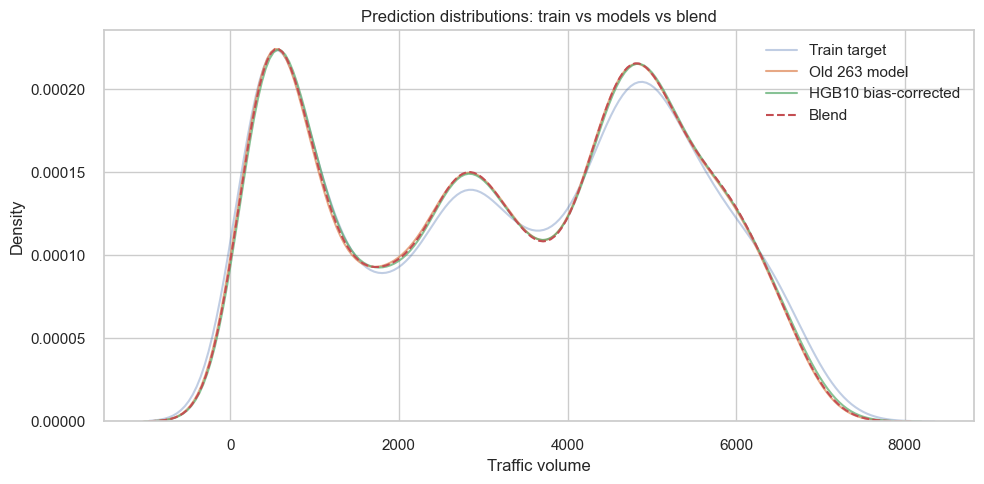

In [3]:
# === Plot provided blended submission curve ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

def _first_existing(paths):
    for path in paths:
        if path and path.exists():
            return path
    return None

ROOT = Path.cwd()
candidate_blend_paths = []
if "blend_path" in globals():
    candidate_blend_paths.append(Path(blend_path))
candidate_blend_paths.extend([
    ROOT / "blended_263_hgb10_bias_corrected.csv",
    ROOT / "BEST_MODEL_261" / "blended_263_hgb10_bias_corrected.csv",
    ROOT.parent / "BEST_MODEL_261" / "blended_263_hgb10_bias_corrected.csv",
])

best_blend_path = _first_existing(candidate_blend_paths)
if best_blend_path is None:
    raise FileNotFoundError(
        "Provided blended submission not found. Ensure blended_263_hgb10_bias_corrected.csv is available.",
    )

best_blend = pd.read_csv(best_blend_path).rename(
    columns={"traffic_volume": "traffic_volume_best"}
)
print(f"[Best curve] Loaded {best_blend_path} ({len(best_blend):,} rows)")

if "train_eng_plot" not in globals():
    train_eng_plot = build_engineered_frame(train_df).reset_index(drop=True)
kaggle_eng_plot = build_engineered_frame(kaggle_df).reset_index(drop=True)
if "ID" not in kaggle_eng_plot.columns:
    kaggle_eng_plot["ID"] = best_blend["ID"].values

merged_best = kaggle_eng_plot.merge(best_blend, on="ID", how="left")
if merged_best["traffic_volume_best"].isna().any():
    missing = merged_best["traffic_volume_best"].isna().sum()
    raise ValueError(
        f"[Best curve] Missing predictions for {missing} Kaggle rows; ensure IDs align.",
    )

full_hours = pd.RangeIndex(24)
hour_profile_train = train_eng_plot.groupby("hour")["traffic_volume"].mean().reindex(full_hours)
hour_profile_best = merged_best.groupby("hour")["traffic_volume_best"].mean().reindex(full_hours)

density_train = train_eng_plot.groupby("hour").size().reindex(full_hours).fillna(0)
density_best = merged_best.groupby("hour").size().reindex(full_hours).fillna(0)
density_train = density_train / density_train.sum()
density_best = density_best / density_best.sum()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(
    x=hour_profile_train.index,
    y=hour_profile_train.values,
    label="Train target mean",
    linewidth=2,
    ax=ax1,
 )
sns.lineplot(
    x=hour_profile_best.index,
    y=hour_profile_best.values,
    label="Provided blend mean",
    linestyle="--",
    ax=ax1,
 )
ax1.set_title("Mean traffic volume by hour: train vs provided blend")
ax1.set_xlabel("Hour of day")
ax1.set_ylabel("Traffic volume")

ax2 = ax1.twinx()
sns.lineplot(
    x=density_train.index,
    y=density_train.values,
    label="Train density",
    linestyle=":",
    color="tab:blue",
    ax=ax2,
 )
sns.lineplot(
    x=density_best.index,
    y=density_best.values,
    label="Blend density",
    linestyle="-.",
    color="tab:red",
    ax=ax2,
 )
ax2.set_ylabel("Density (share of rows)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

fig.tight_layout()
plt.show()

[Best curve] Loaded c:\Users\jbtil\OneDrive\Desktop\Semesters\MSBA\Fall_2025_courses\BZAN_542\homework\Model\old_best_263\BEST_MODEL_261\blended_263_hgb10_bias_corrected.csv (6,572 rows)


NameError: name 'train_df' is not defined

[Blend] Saved blended submission -> blended_263_hgb10_bias_corrected.csv


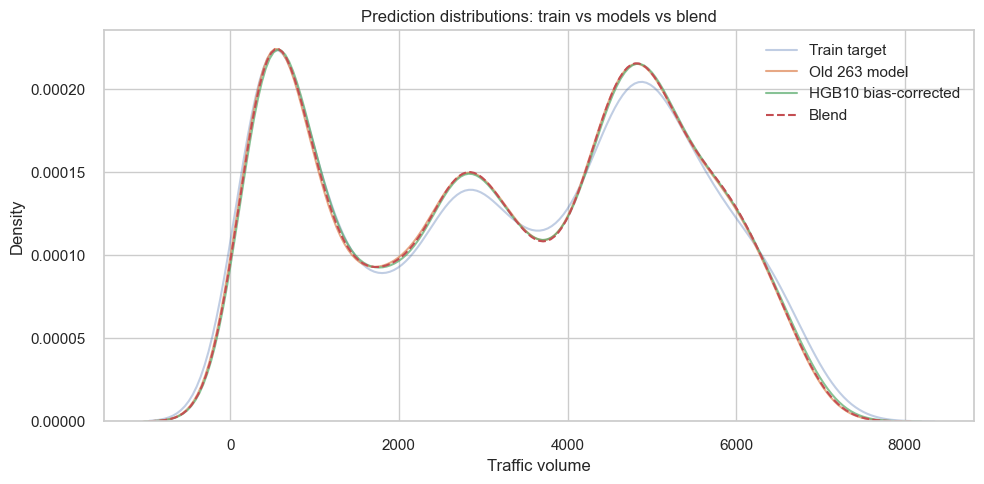

# Final Blend Pipeline (Self-Contained)

## Required Files
**Input:**
- `TRAIN.csv` - Raw training data with columns: `date_time`, `weather_description`, `temp`, `clouds_all`, `traffic_volume`
- `KAGGLE.csv` - Raw test data with columns: `ID`, `date_time`, `weather_description`, `temp`, `clouds_all`
- `prior_best_submission/*.csv` - (Optional) Your best prior submission for blending

## Output Files
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold.csv` - Raw 10-fold predictions
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold_bias_corrected.csv` - Bias-corrected predictions
- `artifacts_hgb_engineered_10fold/bagged_ensemble_engineered_10fold_metrics.json` - CV metrics
- `blended_263_hgb10_bias_corrected.csv` - **Final blended submission**

## Pipeline Steps
1. Load raw data (`TRAIN.csv`, `KAGGLE.csv`)
2. Engineer features (hour, dayofweek, year, dayofyear, weather_final, temp, clouds_all)
3. Train 10-fold HGB ensemble
4. Apply hour-of-week bias correction
5. Blend with prior best submission (98% prior + 2% new)

In [ ]:
# === FINAL BLEND PIPELINE (SELF-CONTAINED) ===
# All-in-one cell: data loading, feature engineering, model training, blending, and submission
from __future__ import annotations

import inspect
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# =============================================================================
# CONFIGURATION
# =============================================================================
# Input data files
RAW_TRAIN_PATH = Path("TRAIN.csv")
RAW_KAGGLE_PATH = Path("KAGGLE.csv")

# Output paths
ARTIFACTS = Path.cwd() / "artifacts_hgb_engineered_10fold"
ARTIFACTS.mkdir(exist_ok=True)
SUBMISSION_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold.csv"
BIAS_CORRECTED_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_bias_corrected.csv"
METRICS_PATH = ARTIFACTS / "bagged_ensemble_engineered_10fold_metrics.json"

# Prior best submission for blending (place your best CSV here)
PRIOR_BEST_DIR = Path.cwd() / "prior_best_submission"
PRIOR_BEST_DIR.mkdir(exist_ok=True)

# Model hyperparameters
BASE_PARAMS = dict(
    learning_rate=0.03,
    max_iter=3000,
    max_depth=18,
    max_leaf_nodes=84,
    min_samples_leaf=15,
    max_bins=160,
    l2_regularization=0.10,
    early_stopping=False,
    scoring="neg_root_mean_squared_error",
)

# Ensemble settings
N_FOLDS = 10
KF_RANDOM_STATE = 2025

# Blend weight (alpha for prior best, 1-alpha for new model)
BLEND_ALPHA = 0.98

# Features used by the model
STABLE_FEATURES = [
    "hour",
    "dayofweek",
    "year",
    "dayofyear",
    "weather_final",
    "temp",
    "clouds_all",
]

# =============================================================================
# FEATURE ENGINEERING (SELF-CONTAINED)
# =============================================================================
def create_weather_final(df: pd.DataFrame) -> np.ndarray:
    """Create validated 8-level weather feature from raw weather_description."""
    desc = df["weather_description"].str.lower().str.strip()
    
    conditions = [
        desc.isin(["sky is clear", "overcast clouds"]),
        desc.isin(["few clouds", "broken clouds", "scattered clouds", "haze"]),
        desc.isin(["mist", "fog"]),
        desc.isin([
            "light rain", "drizzle", "light intensity drizzle",
            "light rain and snow", "light intensity shower rain",
        ]),
        desc.isin([
            "moderate rain", "heavy intensity rain", "freezing rain",
            "heavy intensity drizzle", "shower drizzle", "proximity shower rain",
        ]),
        desc.isin(["light snow", "light shower snow"]),
        desc.isin(["snow", "heavy snow", "sleet", "shower snow"]),
        desc.str.contains("thunderstorm", na=False),
    ]
    
    choices = [
        "Best_Conditions",
        "Cloudy_Hazy",
        "Low_Viz",
        "Rain_Light",
        "Rain_ModHeavy",
        "Snow_Light",
        "Snow_ModHeavy",
        "Thunderstorm",
    ]
    
    return np.select(conditions, choices, default="Other")


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Engineer all required features for the HGB model."""
    data = df.copy()
    
    # Parse datetime
    dt = pd.to_datetime(data["date_time"], utc=False, errors="coerce")
    
    # Time features
    data["hour"] = dt.dt.hour
    data["dayofweek"] = dt.dt.dayofweek
    data["year"] = dt.dt.year
    data["dayofyear"] = dt.dt.dayofyear
    
    # Weather feature
    data["weather_final"] = create_weather_final(data)
    
    # Keep original temp and clouds_all (should already exist)
    # If temp is in Kelvin, convert to Fahrenheit
    if "temp" in data.columns:
        if data["temp"].mean() > 200:  # likely Kelvin
            data["temp"] = (data["temp"] - 273.15) * 9/5 + 32
    
    return data


def _ensure_datetime(series: pd.Series) -> pd.Series:
    """Ensure series is datetime type."""
    if series.dtype.kind == "M":
        return series
    return pd.to_datetime(series, utc=False, errors="coerce")


def build_engineered_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    """Run engineer_features and attach auxiliary fields needed downstream."""
    engineered = engineer_features(df_in)
    frame = engineered.copy()
    
    frame["dayofweek"] = frame["dayofweek"].astype("category")
    frame["weather_final"] = frame["weather_final"].astype("category")
    
    if "traffic_volume" in df_in.columns:
        traffic = df_in["traffic_volume"].astype(float)
        frame["traffic_volume"] = traffic.values
        frame["traffic_volume_log"] = np.log1p(traffic).values
    
    if "ID" in df_in.columns:
        frame["ID"] = df_in["ID"].values
    
    if "date_time" in df_in.columns:
        dt = _ensure_datetime(df_in["date_time"])
        frame["date_time"] = dt
        frame["time_index"] = (dt - dt.min()).dt.total_seconds() / 3600.0
    else:
        frame["time_index"] = np.arange(len(frame), dtype=float)
    
    frame["dayofweek_numeric"] = frame["dayofweek"].astype(str).astype(int)
    frame["day_of_week"] = frame["dayofweek_numeric"]
    frame["hour_of_week"] = frame["dayofweek_numeric"] * 24 + frame["hour"]
    
    return frame.sort_values("time_index").reset_index(drop=True)


def build_X_y(train_eng: pd.DataFrame):
    """Split engineered train frame into X, y using the locked feature set."""
    if "traffic_volume" not in train_eng.columns:
        raise ValueError("Expected column 'traffic_volume' in engineered train frame.")
    
    X = train_eng[STABLE_FEATURES].copy()
    y = train_eng["traffic_volume"].astype(float)
    
    return X, y


def build_kaggle_X(kaggle_eng: pd.DataFrame, train_X_columns: list[str]):
    """Build Kaggle feature frame matching the columns used in training."""
    Xk = kaggle_eng[STABLE_FEATURES].copy()
    
    for col in train_X_columns:
        if col not in Xk.columns:
            Xk[col] = 0.0
    
    return Xk[train_X_columns]


# =============================================================================
# PIPELINE BUILDER
# =============================================================================
def build_pipeline(features: pd.DataFrame) -> Pipeline:
    """Create preprocessing + HGB model pipeline."""
    categorical_cols = features.select_dtypes(include=["object", "category"]).columns.tolist()
    numeric_cols = [col for col in features.columns if col not in categorical_cols]
    
    onehot_kwargs = {"handle_unknown": "ignore"}
    if "sparse_output" in inspect.signature(OneHotEncoder.__init__).parameters:
        onehot_kwargs["sparse_output"] = False
    else:
        onehot_kwargs["sparse"] = False
    
    transformer = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(**onehot_kwargs), categorical_cols),
            ("numeric", "passthrough", numeric_cols),
        ]
    )
    
    model = HistGradientBoostingRegressor(**BASE_PARAMS)
    
    return Pipeline([
        ("preprocessor", transformer),
        ("model", model),
    ])


# =============================================================================
# BIAS CORRECTION
# =============================================================================
def apply_bias_correction(
    train_eng: pd.DataFrame,
    kaggle_eng: pd.DataFrame,
    oof_preds: np.ndarray,
    kaggle_preds: np.ndarray,
) -> np.ndarray:
    """Apply hour-of-week bias correction to Kaggle predictions."""
    y_true = train_eng["traffic_volume"].values
    residuals = y_true - oof_preds
    
    # Compute mean residual per hour_of_week
    train_eng = train_eng.copy()
    train_eng["residual"] = residuals
    hw_bias = train_eng.groupby("hour_of_week")["residual"].mean()
    
    # Apply correction to Kaggle predictions
    kaggle_hw = kaggle_eng["hour_of_week"].values
    corrections = pd.Series(kaggle_hw).map(hw_bias).fillna(0.0).values
    
    corrected = kaggle_preds + corrections
    return np.clip(corrected, 0, None)


# =============================================================================
# MAIN PIPELINE
# =============================================================================
def run_final_blend_pipeline():
    """Execute the complete pipeline: train, predict, correct bias, and blend."""
    
    print("=" * 60)
    print("FINAL BLEND PIPELINE")
    print("=" * 60)
    
    # --- Load Data ---
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv(RAW_TRAIN_PATH, parse_dates=["date_time"])
    kaggle_df = pd.read_csv(RAW_KAGGLE_PATH, parse_dates=["date_time"])
    print(f"  Train: {train_df.shape[0]:,} rows")
    print(f"  Kaggle: {kaggle_df.shape[0]:,} rows")
    
    # --- Engineer Features ---
    print("\n[2/6] Engineering features...")
    train_eng = build_engineered_frame(train_df)
    kaggle_eng = build_engineered_frame(kaggle_df)
    
    X, y = build_X_y(train_eng)
    train_X_cols = X.columns.tolist()
    X_kaggle = build_kaggle_X(kaggle_eng, train_X_cols)
    
    print(f"  Training features: {X.shape}")
    print(f"  Kaggle features: {X_kaggle.shape}")
    print(f"  Features: {train_X_cols}")
    
    # --- Train 10-Fold Ensemble ---
    print(f"\n[3/6] Training {N_FOLDS}-fold HGB ensemble...")
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=KF_RANDOM_STATE)
    
    oof_predictions = np.zeros(len(X), dtype=float)
    prediction_counts = np.zeros(len(X), dtype=float)
    kaggle_predictions = np.zeros(X_kaggle.shape[0], dtype=float)
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"  Fold {fold}/{N_FOLDS}...", end=" ")
        
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        pipeline = build_pipeline(X_train_fold)
        pipeline.fit(X_train_fold, y_train_fold)
        
        val_preds = pipeline.predict(X_val_fold)
        oof_predictions[val_idx] += val_preds
        prediction_counts[val_idx] += 1
        
        fold_rmse = mean_squared_error(y_val_fold, val_preds, squared=False)
        fold_metrics.append({"fold": fold, "rmse": float(fold_rmse)})
        print(f"RMSE: {fold_rmse:.3f}")
        
        kaggle_predictions += pipeline.predict(X_kaggle) / N_FOLDS
    
    prediction_counts[prediction_counts == 0] = 1.0
    oof_predictions /= prediction_counts
    
    overall_oof_rmse = float(mean_squared_error(y, oof_predictions, squared=False))
    print(f"\n  Overall OOF RMSE: {overall_oof_rmse:.3f}")
    
    # Save artifacts
    np.save(ARTIFACTS / "oof_preds.npy", oof_predictions)
    np.save(ARTIFACTS / "y_true.npy", y.to_numpy())
    
    metrics = {
        "overall_oof_rmse": overall_oof_rmse,
        "base_model_params": BASE_PARAMS,
        "n_folds": N_FOLDS,
        "fold_metrics": fold_metrics,
        "feature_columns": train_X_cols,
    }
    METRICS_PATH.write_text(json.dumps(metrics, indent=2))
    
    # Save raw submission
    raw_submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions,
    })
    raw_submission.to_csv(SUBMISSION_PATH, index=False)
    print(f"\n[4/6] Raw submission saved: {SUBMISSION_PATH.name}")
    
    # --- Apply Bias Correction ---
    print("\n[5/6] Applying bias correction...")
    kaggle_predictions_corrected = apply_bias_correction(
        train_eng, kaggle_eng, oof_predictions, kaggle_predictions
    )
    
    corrected_submission = pd.DataFrame({
        "ID": kaggle_eng.get("ID", pd.Series(np.arange(len(X_kaggle)))).values,
        "traffic_volume": kaggle_predictions_corrected,
    })
    corrected_submission.to_csv(BIAS_CORRECTED_PATH, index=False)
    print(f"  Bias-corrected submission saved: {BIAS_CORRECTED_PATH.name}")
    
    # --- Blend with Prior Best ---
    print("\n[6/6] Blending with prior best submission...")
    
    # Find prior best CSV
    prior_best_path = None
    if PRIOR_BEST_DIR.exists():
        csv_files = list(PRIOR_BEST_DIR.glob("*.csv"))
        if csv_files:
            prior_best_path = max(csv_files, key=lambda p: p.stat().st_mtime)
    
    if prior_best_path is None:
        print(f"  WARNING: No prior best CSV found in {PRIOR_BEST_DIR}")
        print(f"  Place your best submission CSV in that folder to enable blending.")
        print(f"  Using bias-corrected submission as final output.")
        final_submission = corrected_submission.copy()
        final_path = BIAS_CORRECTED_PATH.with_name("final_submission.csv")
    else:
        print(f"  Prior best: {prior_best_path.name}")
        prior_best = pd.read_csv(prior_best_path)
        
        merged = prior_best.merge(
            corrected_submission,
            on="ID",
            suffixes=("_prior", "_new")
        )
        
        y_prior = merged["traffic_volume_prior"].to_numpy()
        y_new = merged["traffic_volume_new"].to_numpy()
        y_blend = BLEND_ALPHA * y_prior + (1 - BLEND_ALPHA) * y_new
        
        final_submission = pd.DataFrame({
            "ID": merged["ID"],
            "traffic_volume": y_blend,
        })
        
        final_path = Path.cwd() / "blended_263_hgb10_bias_corrected.csv"
        print(f"  Blend: {BLEND_ALPHA:.0%} prior + {1-BLEND_ALPHA:.0%} new")
    
    final_submission.to_csv(final_path, index=False)
    print(f"  Final submission saved: {final_path.name}")
    
    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    
    return {
        "train_eng": train_eng,
        "kaggle_eng": kaggle_eng,
        "oof_preds": oof_predictions,
        "kaggle_preds": kaggle_predictions,
        "kaggle_preds_corrected": kaggle_predictions_corrected,
        "final_submission": final_submission,
        "metrics": metrics,
    }


# Run the pipeline
results = run_final_blend_pipeline()